# Figure 2: N-end rule substrate degradation declines rapidly after senescence entry point

## Import libraries

In [1]:
from importlib import reload

import os
import re

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import skimage as sk
import os
import re
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import seaborn as sns
from statannotations.Annotator import Annotator

from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter

wbf = WeibullFitter()
kmf = KaplanMeierFitter()

from byc import constants, files, database, segmentation
from byc import standard_analysis as sa
from byc import plotting
from byc import fitting_tools as ft

from byc import constants, plotting, files, database, utilities, trace_tools, fitting_tools, segmentation
from byc import standard_analysis as sa
from byc.trace_tools import median_filter
median_filter
from importlib import reload
for pac in [constants,
            plotting,
            files,
            sa,
            database,
            utilities,
            trace_tools,
            fitting_tools,
            segmentation]:
    reload(pac)
    
plotting.set_styles(plt, matplotlib)

strains_color_dict =  plotting.strains_color_dict
other_colors = plotting.other_colors

# Generate a palette to use for signifying number of 
# buds that will be produced before the last bud
pre_post_SEP_palette = plotting.get_pre_post_sep_palette()

## Generate fits, trace, and buds dataframes *de novo*

Do this after analyzing new experiments in `constants.byc_data_dir` and adding them to the compartments_index.csv at `constants.compartment_index_path`

In [2]:
%%capture refresh_database_printout

scriptpath = os.path.join(constants.source_path, 'bin/refresh_database.py')
%run $scriptpath

## Read in databases

In [2]:
traces_df, fits_df, buds_df = database.read_in_trace_fits_buds_dfs()

C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:646: DtypeWarning: Columns (64,66,71,85,89,90,94,96,97,98,99,100,101,102,103,104,105,106,107,108,172,173,175,177,209,213,214,216,217,218,219) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(savepath, compression='gzip')


Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/traces_df.csv.gzip
Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/fits_df.csv.gzip


C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:646: DtypeWarning: Columns (64,66,83,87,88,141,142,144,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(savepath, compression='gzip')


Read dataframe at
C:\Users\johnp\Dropbox\Projects\byc\data/meta/buds_df.csv.gzip


C:\Users\johnp\Dropbox\Projects\byc\byc\database.py:646: DtypeWarning: Columns (41,50,51,53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(savepath, compression='gzip')


## Plot YFP vs. time after chase traces for individual strains

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=x_input_y=y_input_norm_hue=dist_from_sen_strain=JPC228.svg


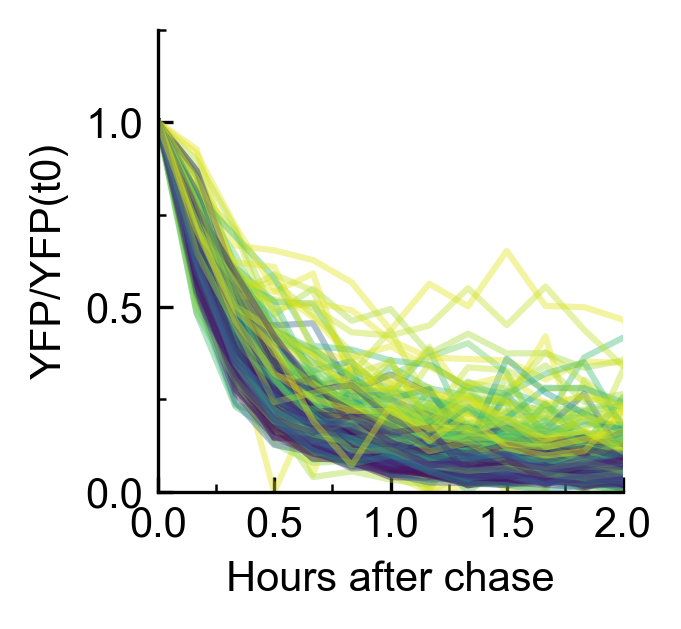

In [5]:
strains = ['JPC228', 'JPC258']
# strains = ['JPC263']
# strains = ['JPC122']
# strains = ['JPC121', 'JPC220', 'JPC146']

if 'JPC228' in strains:
    skip_comps = [
        '20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741_rfp',
        '20221028_byc_JPC228_DsRed-P2A-UBL-YFP-Su9_3x-int',
        '20221019_byc_JPC228_UBL-YFP-Su9_full'
    ]
else:
     skip_comps = []
ratecolor = strains_color_dict[strains[0]]
name= '-'.join(strains)
plot_means = False
filename = f'{name}'

sub_traces_df = traces_df[traces_df.strain_name.isin(strains)]
sub_traces_df = sub_traces_df[sub_traces_df.potential_blue_light_exposure_during_filter_cube_switching==False]
sub_traces_df = sub_traces_df[sub_traces_df.dist_from_sen>-1]
sub_traces_df.loc[:, 'measdex'] = sub_traces_df.measdex.str.cat(sub_traces_df.dist_from_sen.astype(str), sep='-')
sub_traces_df.loc[:, 'dist_from_sen_bin'] = '>7'
sub_traces_df.loc[sub_traces_df.dist_from_sen<=7, 'dist_from_sen_bin'] = '<=7'
sub_traces_df.dropna(subset=['dist_from_sen_bin'], inplace=True)
sub_traces_df = sub_traces_df[~sub_traces_df.compartment_name.isin(skip_comps)]
# Define plotting variables
yvar = 'y_input_norm'
xvar = 'x_input'
huevar = 'dist_from_sen'
alpha = 0.4
size =14
fontsize=10
linewidth = 1
xlim = (0, 2)
ylim = (0, 1.25)
ylabel = 'YFP/YFP(t0)'
xlabel = 'Hours after chase'
# Make palette
max_dist_from_sen = int(sub_traces_df[huevar].max())
max_dist_from_sen = 20
colors = sns.color_palette('viridis', max_dist_from_sen+1)
colors_list = [c for c in colors]
colors_list.reverse()
keys = list(range(max_dist_from_sen+1))
palette_dict = dict(zip(keys, colors_list))

wanted = [
    2,
    20
    ]
median_colors = [colors_list[i] for i in wanted]
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
# Subsample so we're not overplotting too much
n_cells_to_sample = 300
random_seed = 1
if len(sub_traces_df.measdex.unique()) >= n_cells_to_sample:
    measdices_to_plot = np.random.choice(sub_traces_df.measdex.unique(), n_cells_to_sample, replace=False)
else:
    measdices_to_plot = sub_traces_df.measdex.unique()

previous_measdices = []
for measdex in measdices_to_plot:
    # Making sure I don't plot duplicates
    if measdex not in previous_measdices:
        subdf = sub_traces_df.set_index('measdex').loc[measdex, :].reset_index()
        subdf.sort_values(by=xvar, inplace=True, ascending=True)
        bin_name = subdf.loc[0, 'dist_from_sen_bin']
        dist_from_sen = subdf.loc[0, huevar]
        key = int(dist_from_sen)
        if key > max_dist_from_sen:
            key = max_dist_from_sen
        color = palette_dict[key]
        ax.plot(subdf[xvar], subdf[yvar], color=color, alpha=alpha)
    else:
        print(f'Duplicate measurements:\n{measdex}')
    previous_measdices.append(measdex)


linekwargs = {
    'x': xvar,
    'y': yvar,
    'data': subdf,
    'hue': huevar,
    'ax': ax,
    'estimator': 'mean',
    'palette': median_colors,
    'hue_order': sub_traces_df[huevar].unique()
}
if plot_means:
    sns.lineplot(**linekwargs)
    L=ax.legend(title="Buds before death.", frameon=False)
    labels = df[huevar].unique()

    for idx in range(len(labels)):
        L.get_texts()[idx].set_text(labels[idx])


ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_xticks(np.arange(0, 2.1, 0.5))

plotting.remove_spines(ax)
plotting.format_ticks(ax)

ax.set_ylabel(ylabel, fontsize=fontsize, color='black')
ax.set_xlabel(xlabel, fontsize=fontsize)

linekwargs['strain'] = strains[0]
plotting.save_figure(fig, linekwargs, ext='.svg')

Make color palette key for above

In [38]:
reload(plotting)

<module 'byc.plotting' from 'C:\\Users\\johnp\\Dropbox\\Projects\\byc\\byc\\plotting.py'>

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\notebooks\plots\gen_from_death_color_palette_max_dist_from_sen=20.svg


C:\Users\johnp\Dropbox\Projects\byc\byc\plotting.py:1091: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


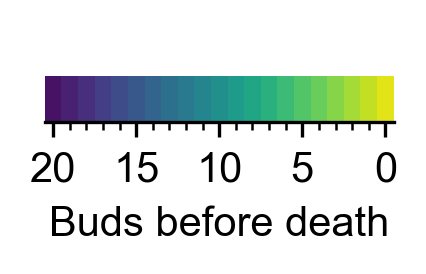

In [5]:
plotting.plot_dist_from_sen_palette_key(max_dist_from_sen=max_dist_from_sen,
                                        direction='declining',
                                        xlabel='Buds before death')

## Plot rate constants vs. buds before death

In [209]:
buds_df.loc[buds_df.compartment_name=='20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741_rfp', 'strain_name'] = 'JPC258_r'

Saved logistic fit results at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC228_linear-fit_b-vs-dist-from-sen.csv
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_y=k and cycle duration_strains=JPC258-JPC228.svg


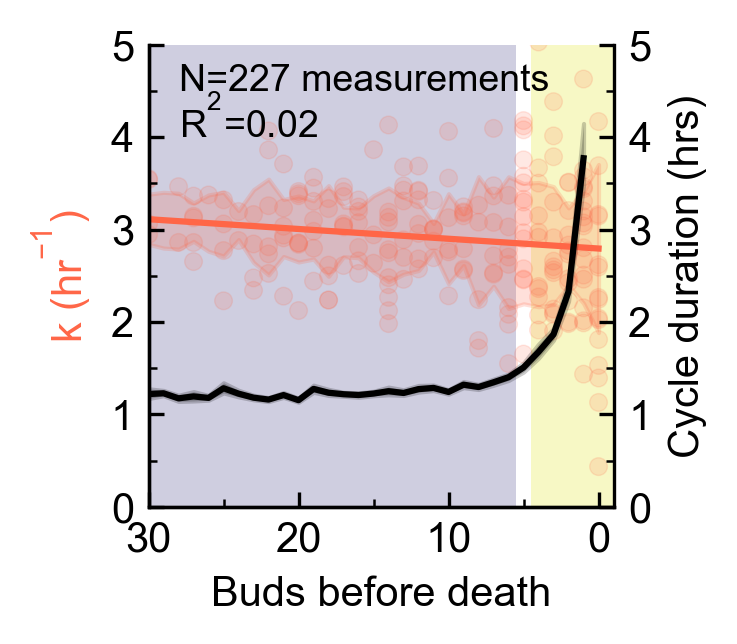

In [6]:
reload(fitting_tools)
# strains = ['JPC121', 'JPC146', 'JPC220']
# strains = ['JPC122']
strains = ['JPC258', 'JPC228']
# strains = ['JPC199']
# strains = ['JPC193']
# strains = ['JPC262']
# strains = ['JPC136']

skip_comps = [
     '20221104_byc_JPC136_R-YFP-Su9_UBR1-OE',
     '20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741_rfp'
]

pre_load_vortex = False
blue_light_exposed = False

sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]
# sub_fits_df = sub_fits_df[sub_fits_df['tet_stock_concn']=='1000X']
# sub_fits_df = sub_fits_df[sub_fits_df['pre-load-vortex']==pre_load_vortex]
# sub_fits_df = sub_fits_df[sub_fits_df['potential_blue_light_exposure_during_filter_cube_switching']==blue_light_exposed]
sub_fits_df = sub_fits_df[sub_fits_df.dist_from_sen>=0]
sub_fits_df = sub_fits_df[~sub_fits_df.b.isna()]
sub_fits_df = sub_fits_df[~sub_fits_df.compartment_name.isin(skip_comps)]
sub_bud_df = buds_df[buds_df.strain_name.isin(strains)]
# sub_bud_df = sub_bud_df[sub_bud_df['tet_stock_concn']=='1000X']
# sub_bud_df = sub_bud_df[sub_bud_df['pre-load-vortex']==pre_load_vortex]
# sub_bud_df = sub_bud_df[sub_bud_df['potential_blue_light_exposure_during_filter_cube_switching']==blue_light_exposed]
sub_bud_df = sub_bud_df[~sub_bud_df.compartment_name.isin(skip_comps)]

ratecolor = strains_color_dict[strains[0]]
postsep_border = 5
fit_type = 'line'
xlim = (30, -1)
ylim = (0, 5)
shade_stderr = True
fillalpha = 0.25
fillsep = True
daughter_shape='All'
fig, ax = plotting.figure_ax(width_scale=1)
fig.set_dpi(300)
yvar1 = 'b'
yvar2 = 'cycle_duration_hrs'
xvar = 'dist_from_sen'
alpha = 0.15
size = 15
fontsize=10
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Buds before death'
if fillsep:
    # Shade post-SEP area
    xfill = np.arange(-1, postsep_border, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[1],
        alpha=fillalpha,
        edgecolor=None)
    # Shade post-SEP area
    xfill = np.arange(postsep_border + 0.5, np.max(xlim) + 0.5, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[0],
        alpha=fillalpha,
        edgecolor=None)

if fit_type=='logistic':
    # fit to logistic
        fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
        kernsize = 3
        trace_tools.mean_filter(
            smoothdf,
            'stderr',
            kernsize,
            name_with_kernel=True)  

        params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
        x = np.sort(sub_fits_df[xvar].unique())
        x = np.arange(-10, 40, 1)
        y_pred = fitting_tools.logistic(x, *params)
        ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='line':
    # Fit to line
    fitsdf, smoothdf, result = fitting_tools.fit_line_to_fits_df(sub_fits_df, return_result=True)
    kernsize = 3
    trace_tools.mean_filter(
        smoothdf,
        'stderr',
        kernsize,
        name_with_kernel=True)  
    x = np.sort(sub_fits_df[xvar].unique())
    params = (fitsdf.m.iloc[0], fitsdf.b.iloc[0])
    y_pred = fitting_tools.line(x, *params)
    ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='median':
     
    sns.lineplot(x=xvar, y=yvar1, data=sub_fits_df, ax=ax, color=ratecolor, estimator='mean')
    # Get stats for 
    x = sub_fits_df.sort_values(by='dist_from_sen', ascending=True)[xvar].unique()
    y_pred = sub_fits_df.sort_values(by='dist_from_sen', ascending=True).loc[:, [xvar, yvar1]].pivot_table(index=[xvar], aggfunc='mean').values
    y_pred = np.reshape(y_pred, len(y_pred))

else:
    print(f'No fit type <{fit_type}>. Please use either logistic or line')
# Derive statistics of fit
r_sq, ydata, ypred = fitting_tools.get_r_sq_with_multi_y_per_x(x, y_pred, sub_fits_df, return_new_y_ypreds=True)
n = len(sub_fits_df)
# Shade standard error of the mean for 
if shade_stderr:
    xvar_fill = 'x_input_smooth'
    yvar_fill = 'y_pred'
    errvar = f'stderr'
    # errvar = f'stderr'

    err_kwargs = {
        'x': smoothdf[xvar_fill],
        'y1': smoothdf[yvar_fill] + smoothdf[errvar],
        'y2': smoothdf[yvar_fill] - smoothdf[errvar]
    }

    kwargs = {
        'x': xvar_fill,
        'y': 'y_pred',
        'data': smoothdf,
        'err_kws': err_kwargs
    }
    ax.fill_between(
        err_kwargs['x'],
        err_kwargs['y1'],
        err_kwargs['y2'],
        color=ratecolor,
        alpha=0.2
        )
# Format axes
ax.set_xlim(xlim)
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_xticks(np.arange(0, xlim[0]+1, 10))
ax.set_ylim(ylim)
ax.set_yticks(np.arange(0, ylim[1]+0.1, 1))
ax2 = ax.twinx()
ax2.set_ylim(ylim)
ax2.set_yticks(np.arange(0, ylim[1]+0.1, 1))
# plot cycle durations
sns.lineplot(x=xvar, y=yvar2, data=sub_bud_df,ax=ax2, color='black')
# Plot rate constants
kwargs = {
    'x': xvar,
    'y': yvar1,
    'alpha': alpha,
    'data': sub_fits_df,
    'ax': ax,
    'size': size,
    'color': ratecolor,
    'edgecolor': ratecolor + (0,) #The (0, ) tuple adds alpha to the ratecolor tuple
}
sns.scatterplot(**kwargs)
ax.legend_.set_visible(False)
# Aesthetics
plotting.remove_spines(ax)
plotting.format_ticks(ax)
plotting.format_ticks(ax2)
ax2.spines['top'].set_visible(False)

ax2.set_ylabel(ylabel1, fontsize=fontsize)
ax.set_ylabel(ylabel2, color=ratecolor, fontsize=fontsize)

# Annotate stats
xy_n = (np.max(ax.get_xlim()) - 2, 4.5)
xy_rsq = (np.max(ax.get_xlim()) - 2, 4.0)
rsq_str = f'{plotting.annoying_strings().r_sq}={np.round(r_sq, 2)}'
n_str = f'N={np.round(n, 2)} measurements'
if fit_type == 'median':
    # Still annotating an R sq. even though the model
    # is just the mean over dist_from_sen
    pass
    # ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1)
else:
    ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1)
ax.annotate(n_str, xy_n, fontsize=fontsize-1)
kwargs = {
    'x': 'dist_from_sen',
    'y': 'k and cycle duration',
    'strains': '-'.join(strains)
}

plotting.save_figure(fig, kwargs, ext='.svg')

### Plot of DsRed decay rate approaching senescence

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_y=k and cycle duration_strains=JPC263.svg


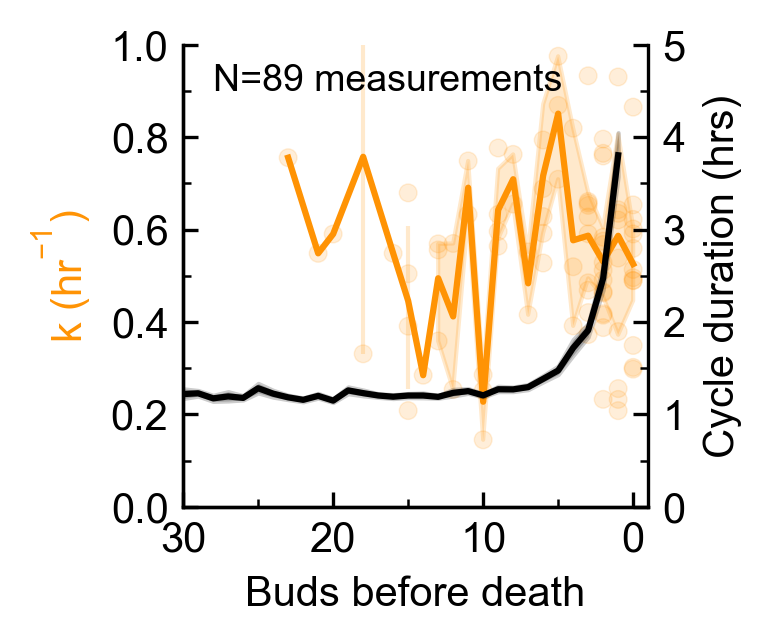

In [237]:
reload(fitting_tools)
# strains = ['JPC121', 'JPC146', 'JPC220']
# strains = ['JPC122']
# strains = ['JPC258', 'JPC228']
# strains = ['JPC199']
# strains = ['JPC193']
# strains = ['JPC262']
# strains = ['JPC136']
# strains = ['JPC258_r']
strains = ['JPC263']

skip_comps = [
     '20221104_byc_JPC136_R-YFP-Su9_UBR1-OE',
     '20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741_rfp'
]

skip_comps = []

pre_load_vortex = False
blue_light_exposed = False

sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]
# sub_fits_df = sub_fits_df[sub_fits_df['tet_stock_concn']=='1000X']
# sub_fits_df = sub_fits_df[sub_fits_df['pre-load-vortex']==pre_load_vortex]
# sub_fits_df = sub_fits_df[sub_fits_df['potential_blue_light_exposure_during_filter_cube_switching']==blue_light_exposed]
sub_fits_df = sub_fits_df[sub_fits_df.dist_from_sen>=0]
sub_fits_df = sub_fits_df[~sub_fits_df.b.isna()]
sub_fits_df = sub_fits_df[~sub_fits_df.compartment_name.isin(skip_comps)]
sub_bud_df = buds_df[buds_df.strain_name.isin(['JPC258'])]
# sub_bud_df = sub_bud_df[sub_bud_df['tet_stock_concn']=='1000X']
# sub_bud_df = sub_bud_df[sub_bud_df['pre-load-vortex']==pre_load_vortex]
# sub_bud_df = sub_bud_df[sub_bud_df['potential_blue_light_exposure_during_filter_cube_switching']==blue_light_exposed]
sub_bud_df = sub_bud_df[~sub_bud_df.compartment_name.isin(skip_comps)]

ratecolor = plotting.strains_color_dict[strains[0]]
postsep_border = 5
fit_type = 'median'
xlim = (30, -1)
ylim = (0, 1)
ylim2 = (0, 5)
shade_stderr = False
fillalpha = 0.25
fillsep = False
daughter_shape='All'
fig, ax = plotting.figure_ax(width_scale=1)
fig.set_dpi(300)
yvar1 = 'b'
yvar2 = 'cycle_duration_hrs'
xvar = 'dist_from_sen'
alpha = 0.15
size = 15
fontsize=10
ylabel1 = 'Cycle duration (hrs)'
ylabel2 = 'k (hr$^{-1}$)'
xlabel = 'Buds before death'
if fillsep:
    # Shade post-SEP area
    xfill = np.arange(-1, postsep_border, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[1],
        alpha=fillalpha,
        edgecolor=None)
    # Shade post-SEP area
    xfill = np.arange(postsep_border + 0.5, np.max(xlim) + 0.5, 0.5)
    ax.fill_between(
        xfill,
        np.full(len(xfill), np.max(ylim)),
        color=pre_post_SEP_palette[0],
        alpha=fillalpha,
        edgecolor=None)

if fit_type=='logistic':
    # fit to logistic
        fitsdf, smoothdf, result = fitting_tools.fit_logistic_to_fits_df(sub_fits_df, return_result=True)
        kernsize = 3
        trace_tools.mean_filter(
            smoothdf,
            'stderr',
            kernsize,
            name_with_kernel=True)  

        params = (fitsdf.L.iloc[0], fitsdf.k.iloc[0], fitsdf.x_center.iloc[0], fitsdf.offset.iloc[0])
        x = np.sort(sub_fits_df[xvar].unique())
        x = np.arange(-10, 40, 1)
        y_pred = fitting_tools.logistic(x, *params)
        ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='line':
    # Fit to line
    fitsdf, smoothdf, result = fitting_tools.fit_line_to_fits_df(sub_fits_df, return_result=True)
    kernsize = 3
    trace_tools.mean_filter(
        smoothdf,
        'stderr',
        kernsize,
        name_with_kernel=True)  
    x = np.sort(sub_fits_df[xvar].unique())
    params = (fitsdf.m.iloc[0], fitsdf.b.iloc[0])
    y_pred = fitting_tools.line(x, *params)
    ax.plot(x, y_pred, color=ratecolor)

elif fit_type=='median':
     
    sns.lineplot(x=xvar, y=yvar1, data=sub_fits_df, ax=ax, color=ratecolor, estimator='mean')
    # Get stats for 
    x = sub_fits_df.sort_values(by='dist_from_sen', ascending=True)[xvar].unique()
    y_pred = sub_fits_df.sort_values(by='dist_from_sen', ascending=True).loc[:, [xvar, yvar1]].pivot_table(index=[xvar], aggfunc='mean').values
    y_pred = np.reshape(y_pred, len(y_pred))

else:
    print(f'No fit type <{fit_type}>. Please use either logistic or line')
# Derive statistics of fit
r_sq, ydata, ypred = fitting_tools.get_r_sq_with_multi_y_per_x(x, y_pred, sub_fits_df, return_new_y_ypreds=True)
n = len(sub_fits_df)
# Shade standard error of the mean for 
if shade_stderr:
    xvar_fill = 'x_input_smooth'
    yvar_fill = 'y_pred'
    errvar = f'stderr'
    # errvar = f'stderr'

    err_kwargs = {
        'x': smoothdf[xvar_fill],
        'y1': smoothdf[yvar_fill] + smoothdf[errvar],
        'y2': smoothdf[yvar_fill] - smoothdf[errvar]
    }

    kwargs = {
        'x': xvar_fill,
        'y': 'y_pred',
        'data': smoothdf,
        'err_kws': err_kwargs
    }
    ax.fill_between(
        err_kwargs['x'],
        err_kwargs['y1'],
        err_kwargs['y2'],
        color=ratecolor,
        alpha=0.2
        )
# Format axes
ax.set_xlim(xlim)
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_xticks(np.arange(0, xlim[0]+1, 10))
ax.set_ylim(ylim)
ax.set_yticks(np.arange(0, ylim[1]+0.1, 0.2))
ax2 = ax.twinx()
ax2.set_ylim(ylim2)
ax2.set_yticks(np.arange(0, ylim2[1]+0.1, 1))
# plot cycle durations
sns.lineplot(x=xvar, y=yvar2, data=sub_bud_df,ax=ax2, color='black')
# Plot rate constants
kwargs = {
    'x': xvar,
    'y': yvar1,
    'alpha': alpha,
    'data': sub_fits_df,
    'ax': ax,
    'size': size,
    'color': ratecolor,
    'edgecolor': ratecolor + (0,) #The (0, ) tuple adds alpha to the ratecolor tuple
}
sns.scatterplot(**kwargs)
ax.legend_.set_visible(False)
# Aesthetics
plotting.remove_spines(ax)
plotting.format_ticks(ax)
plotting.format_ticks(ax2)
ax2.spines['top'].set_visible(False)

ax2.set_ylabel(ylabel1, fontsize=fontsize)
ax.set_ylabel(ylabel2, color=ratecolor, fontsize=fontsize)

# Annotate stats
xy_n = (np.max(ax.get_xlim()) - 2, 0.9)
xy_rsq = (np.max(ax.get_xlim()) - 2, 0.8)
rsq_str = f'{plotting.annoying_strings().r_sq}={np.round(r_sq, 2)}'
n_str = f'N={np.round(n, 2)} measurements'
if fit_type == 'median':
    # Still annotating an R sq. even though the model
    # is just the mean over dist_from_sen
    pass
    # ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1)
else:
    ax.annotate(rsq_str, xy_rsq, fontsize=fontsize-1)
ax.annotate(n_str, xy_n, fontsize=fontsize-1)
kwargs = {
    'x': 'dist_from_sen',
    'y': 'k and cycle duration',
    'strains': '-'.join(strains)
}

plotting.save_figure(fig, kwargs, ext='.svg')

In [11]:
result

In [4]:
result

### Scanning SEP border to find maximum effect size

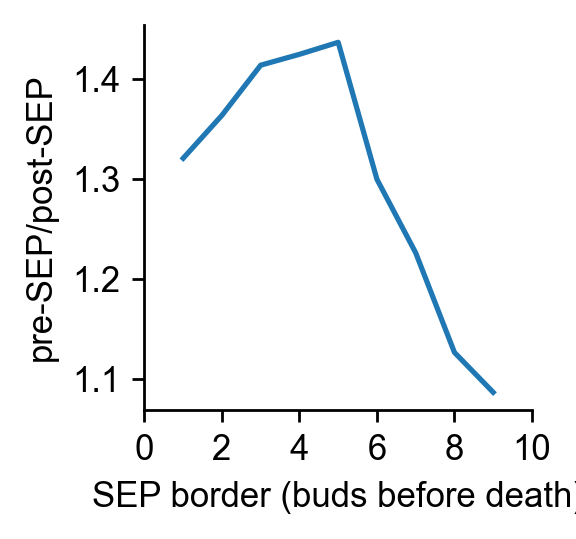

In [93]:
effects = []
borders = []
pre_means = []
post_means = []

window_size = 5
for sep_border in np.arange(1, 10, 1):
    preSEP_bool = sub_fits_df.dist_from_sen.between(sep_border, sep_border + window_size)
    postSEP_bool = sub_fits_df.dist_from_sen.between(sep_border - window_size, sep_border)
    pre_mean = np.mean(sub_fits_df.loc[preSEP_bool].b)
    post_mean = np.mean(sub_fits_df.loc[postSEP_bool].b)
    pre_means.append(pre_mean)
    post_means.append(post_mean)
    effects.append(pre_mean/post_mean)
    borders.append(sep_border)
    
fig, ax = plotting.figure_ax()
ax.plot(borders, effects)
ax.set_ylabel('pre-SEP/post-SEP')
ax.set_xlabel('SEP border (buds before death)')
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 2))

### Does degradation correlate with signal at t0?

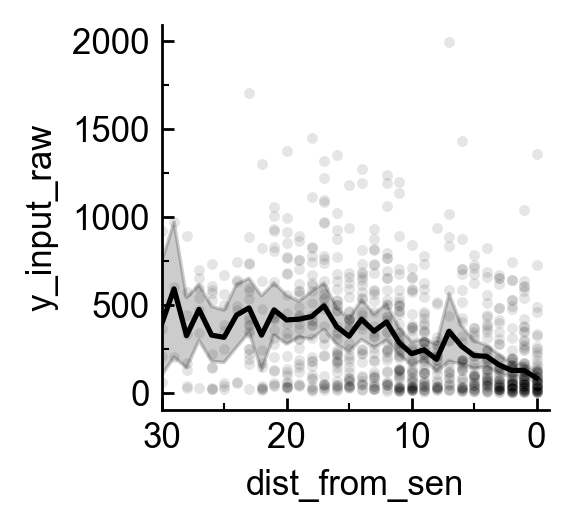

In [138]:
sub_trace_df = traces_df[traces_df.strain_name.isin(strains)]
sub_trace_table = sub_trace_df[sub_trace_df.x_input==0]

fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'dist_from_sen',
    'y': 'y_input_raw',
    'data': sub_trace_table[sub_trace_table.dist_from_sen>-1],
    'ax': ax,
    'color': 'black',
}

sns.lineplot(**kwargs)
sns.scatterplot(**kwargs, alpha=0.1, s=10)
ax.set_xlim(30, -1)
# ax.set_ylim(0, 100)
ax.set_xticks(np.arange(0, 31, 10))
plotting.format_ticks(ax)

<Axes: xlabel='y_input_raw', ylabel='b'>

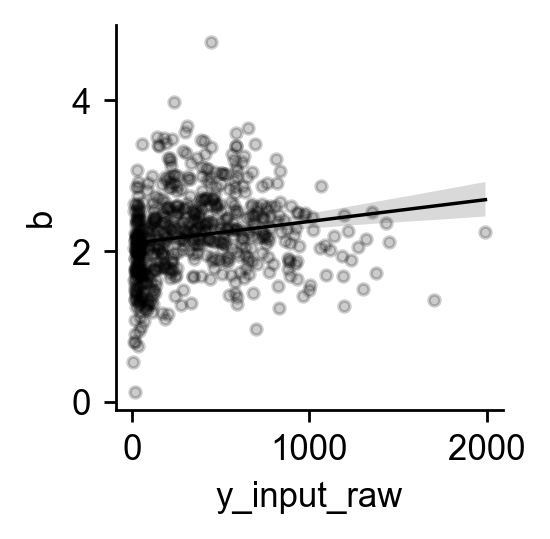

In [140]:
sub_trace_df = traces_df[traces_df.strain_name.isin(strains)]
sub_trace_table = sub_trace_df[sub_trace_df.x_input==0]

fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'y_input_raw',
    'y': 'b',
    'data': sub_trace_table[sub_trace_table.dist_from_sen>5],
    'ax': ax,
    'color': 'black',
    'line_kws': {'linewidth': 1},
    'scatter_kws': {'s': 10, 'alpha': 0.2, 'edgecolor':'black'}
}

sns.regplot(**kwargs)

# ax.set_xscale('log', base=10)

### Half life vs. buds before death

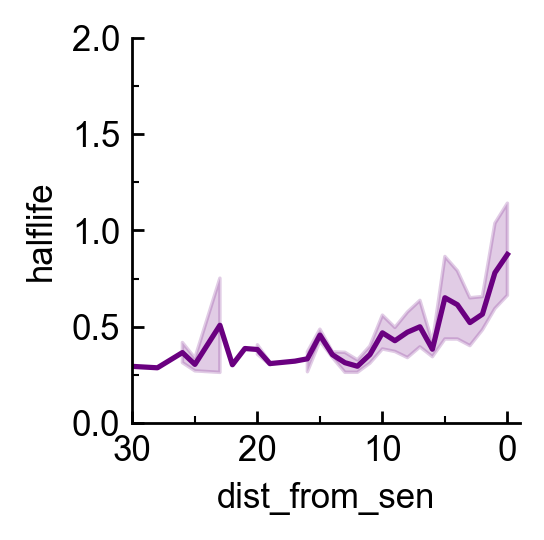

In [12]:
fig, ax = plotting.figure_ax()
sub_fits_df.loc[:, 'halflife'] = np.log(2)/sub_fits_df.b
kwargs = {
    'x': 'dist_from_sen',
    'y': 'halflife',
    'data': sub_fits_df,
    'ax': ax,
    'color': ratecolor
}

sns.lineplot(**kwargs)

ax.set_xlim(30, -1)
ax.set_ylim(0, 2)
ax.set_xticks(np.arange(0, ax.get_xlim()[0]+0.1, 10))
plotting.format_ticks(ax)

## Before and after sep strip plot - above strain only

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.294e-01 U_stat=9.020e+02
Fold change young over old=1.0741349726754048
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=post_sep_y=b_color=(1.0, 0.5764705882352941, 0.01568627450980392).svg


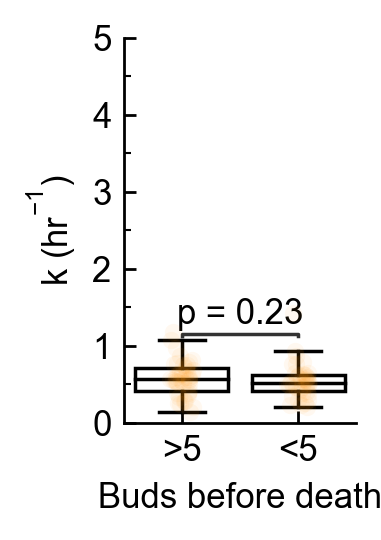

In [238]:
fig, ax = plotting.figure_ax(width_scale=0.6)
sep_border = 5
sub_fits_df.loc[sub_fits_df.dist_from_sen>3, 'post_sep'] = False
sub_fits_df.loc[sub_fits_df.dist_from_sen<3, 'post_sep'] = True

kwargs = {
    'x': 'post_sep',
    'y': 'b',
    'data': sub_fits_df[~sub_fits_df.post_sep.isna()],
    'ax': ax,
    'color': ratecolor
}

sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict, showfliers=False)
# annotate t-test results
data=kwargs['data']
x = kwargs['x']
y = kwargs['y']
box_pairs=[
    (True, False)
]
test='Mann-Whitney'
text_format="simple"
loc="inside"
annotator = Annotator(ax, box_pairs, data=data, x=x, y=y, )
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1)
annotator.apply_and_annotate()
# Plots strips after annotating so annotator
# doesn't dodge all the way up to individaul outliers
sns.stripplot(**kwargs, alpha=0.06)
ax.set_ylim(0, 5)
ax.set_yticks(np.arange(0, ax.get_ylim()[1]+0.01, 1))
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.set_xticklabels(['>5', '<5'])
ax.set_xlabel('Buds before death')
fold_change = sub_fits_df.loc[sub_fits_df.post_sep==False, 'b'].mean()/sub_fits_df.loc[sub_fits_df.post_sep==True, 'b'].mean()
print(f'Fold change young over old={fold_change}')

plotting.format_ticks(ax, add_minor_x=False)
plotting.save_figure(fig, kwargs, ext='.svg')

### Histograms of pre/post SEP

Text(0.5, 1.0, 'Cells <5 buds\nbuds before death')

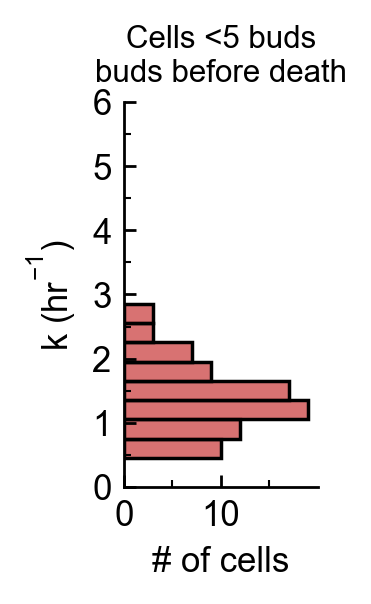

In [174]:
fig, ax = plotting.figure_ax(width_scale=0.5)

kwargs = {
    'y': 'b',
    'data': sub_fits_df[sub_fits_df.dist_from_sen<5],
    'ax': ax,
    'hue_order': [False, True],
    'color': ratecolor,
    'alpha': 0.7,
    'kde': False
}

sns.histplot(**kwargs)

ax.set_ylim(0, 6)
ax.set_yticks(np.arange(0, np.max(ax.get_ylim())+0.1, 1))

ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.set_xlabel('# of cells')
plotting.format_ticks(ax)
ax.set_title('Cells <5 buds\nbuds before death', fontsize=9)

## Swarm plot of k vs. pre/post SEP vs. substrate

In [27]:
ax.get_xticklabels()

[Text(0, 0, 'R*KK'), Text(1, 0, 'UBL'), Text(2, 0, 'ODC(47)')]

C:\Users\johnp\AppData\Local\Temp\ipykernel_11592\1745928538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_fits_df.loc[sub_fits_df.dist_from_sen>5, 'post_sep'] = False


UBL_False vs. UBL_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.064e-02 U_stat=6.015e+03
R*KK_False vs. R*KK_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.177e-61 U_stat=1.859e+05
ODC(47)_False vs. ODC(47)_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=4.420e+04
R*KK fold change young over old=1.5556394007778533 +/- 0.03204848321724078
R*KK fold change old over young=0.642822494403252
UBL fold change young over old=1.0820715706940027 +/- 0.06130777594588408
UBL fold change old over young=0.9241532880848492
ODC(47) fold change young over old=0.98532114343786 +/- 0.04246343662746108
ODC(47) fold change old over young=1.0148975353466225
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=substrate_y=b_hue=post_sep_dodge=True.svg


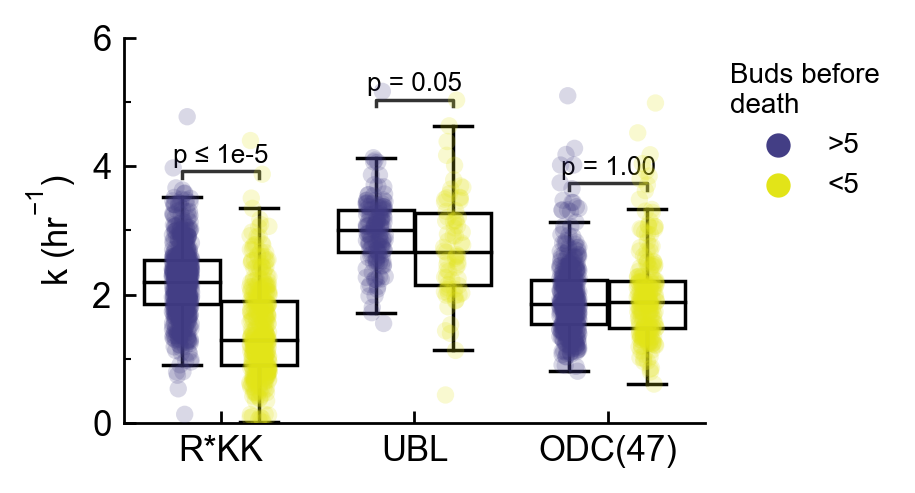

In [26]:
strain_groups = [
    ['JPC121', 'JPC146', 'JPC220'],
    ['JPC228', 'JPC258'],
    ['JPC122']
]

substrates = [
    'R*KK',
    'UBL',
    'ODC(47)'
]
colors = [plotting.strains_color_dict[strain] for strain in ['JPC121', 'JPC228', 'JPC122']]
all_strains = strain_groups[0] + strain_groups[1] + strain_groups[2]
sub_fits_df = fits_df[fits_df.strain_name.isin(all_strains)]
for i, group in enumerate(strain_groups):
    sub_fits_df.loc[sub_fits_df.strain_name.isin(group), 'substrate'] = substrates[i]

fig, ax = plotting.figure_ax(width_scale=1.5)
sub_fits_df.loc[sub_fits_df.dist_from_sen>5, 'post_sep'] = False
sub_fits_df.loc[sub_fits_df.dist_from_sen<5, 'post_sep'] = True

kwargs = {
    'x': 'substrate',
    'y': 'b',
    'hue': 'post_sep',
    'data': sub_fits_df[~sub_fits_df.post_sep.isna()],
    'ax': ax,
    'palette': plotting.get_pre_post_sep_palette(),
    'dodge': True,
    'order': substrates,
    'hue_order': [False, True]
}

sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict, showfliers=False)
# annotate t-test results
data=kwargs['data']
x = kwargs['x']
y = kwargs['y']
hue = kwargs['hue']
order = kwargs['order']
box_pairs=[
    (('UBL', True), ("UBL", False)),
    (("ODC(47)", True), ("ODC(47)", False)),
    (("R*KK", True), ("R*KK", False))
]
test='Mann-Whitney'
text_format="full"
text_format="simple"
loc="inside"

annotator = Annotator(ax, box_pairs, hue=hue, data=data, x=x, y=y, order=order,)
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1, fontsize=7.5,
                    comparisons_correction="bonferroni",)
annotator.apply_and_annotate()
# Wait to plot strip so that the annotator won't plot
# All the way up at the highest outlier
sns.stripplot(**kwargs, alpha=0.2)
ax.set_ylim(0, 6)
ax.set_yticks(np.arange(0, ax.get_ylim()[1]+0.01, 2))
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.set_xlabel('')
for substrate in substrates:
    subdf = sub_fits_df[sub_fits_df.substrate==substrate]
    data1 = subdf.loc[subdf.post_sep==False, 'b']
    data2 = subdf.loc[subdf.post_sep==True, 'b']
    fold_change = data1.mean()/data2.mean()
    SEM1 = np.std(data1, ddof=1) / np.sqrt(np.size(data1))
    SEM2 = np.std(data2, ddof=1) / np.sqrt(np.size(data2))
    SEM_of_fold_change = np.sqrt(np.sum([np.power(SEM1, 2), np.power(SEM1, 2)]))
    fold_change_old_over_young = 1/fold_change
    print(f'{substrate} fold change young over old={fold_change} +/- {SEM_of_fold_change}')
    print(f'{substrate} fold change old over young={fold_change_old_over_young}')
# ax.legend_.set_visible(False)
legfontsize = 8
legend = ax.legend(ax.get_legend_handles_labels()[0][2:], ['>5', '<5'],
                   title='Buds before\ndeath',
                   frameon=False,
                   fontsize=legfontsize,
                   bbox_to_anchor=(1, 1))
legend.get_title().set_fontsize(legfontsize)
plotting.format_ticks(ax, add_minor_x=False)
plotting.save_figure(fig, kwargs, ext='.svg')

## Degradation of RKK and UBL and ODC in WT and rpn4&Delta;

rpn4d-UBL_True vs. rpn4d-UBL_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.776e+03
WT-UBL_True vs. WT-UBL_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.182e-01 U_stat=3.995e+03
WT-ODC_True vs. WT-ODC_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=4.399e+04
rpn4d-ODC_True vs. rpn4d-ODC_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.473e-02 U_stat=6.660e+02
WT-RKK_True vs. WT-RKK_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.080e-61 U_stat=4.231e+04
rpn4d-RKK_True vs. rpn4d-RKK_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.390e+02
WT-DsRed_True vs. WT-DsRed_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.807e-09 U_stat=1.270e+02
Saved figure at 
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\fig2_JPC258-J

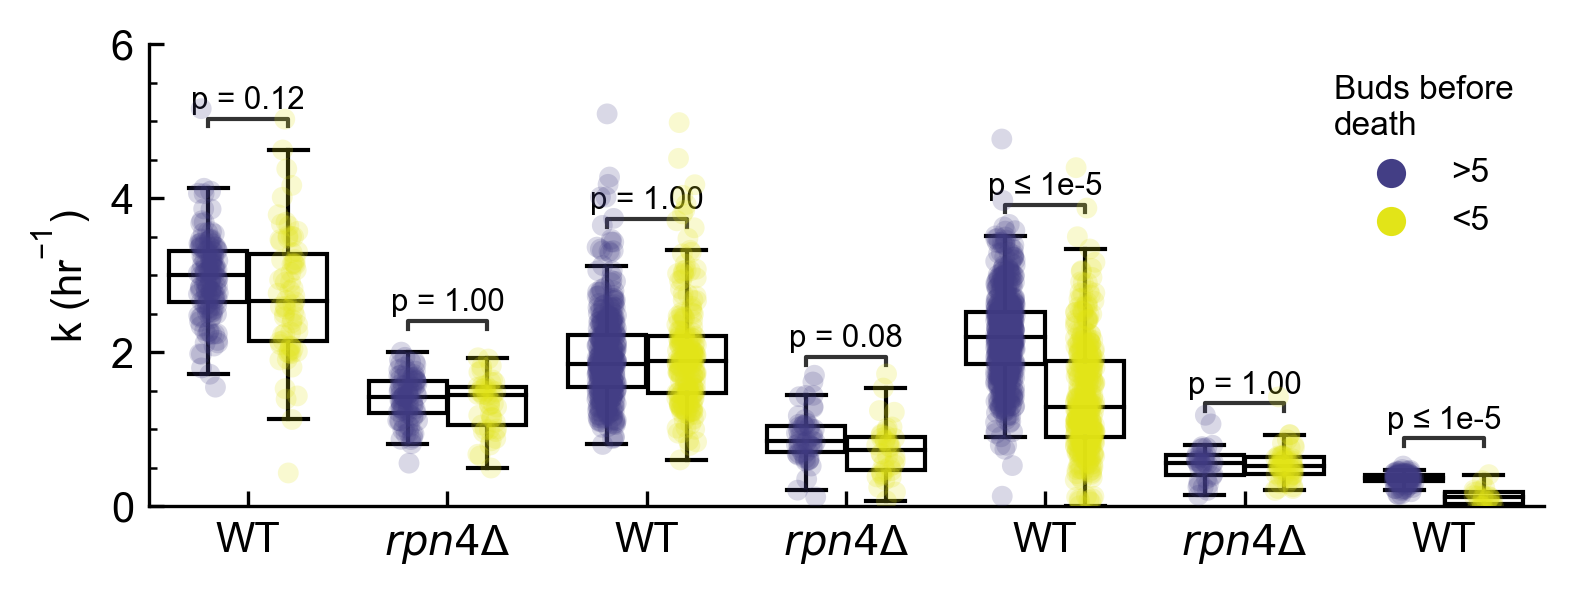

In [35]:
fits_df.loc[fits_df.compartment_name=='20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741_rfp', 'strain_name'] = 'JPC258_r'
from statannotations.Annotator import Annotator
strain_groups = [
    ['JPC258', 'JPC228'],
    ['JPC257'],
    ['JPC122'],
    ['JPC261'],
    ['JPC121', 'JPC146', 'JPC220'],
    ['JPC263'],
    ['JPC258_r']    
]
# strain_groups = strain_groups[0:
strains = []
for group in strain_groups:
    for strain in group:
        strains.append(strain)

bg_substrates = [
    'WT-UBL',
    'rpn4d-UBL',
    'WT-ODC',
    'rpn4d-ODC',
    'WT-RKK',
    'rpn4d-RKK',
    'WT-DsRed'
]

# bg_substrates = bg_substrates[0:4]

skip_comps = [
]

bound1 = 5
bound2 = 5
fits_df.loc[:, 'post-sep'] = np.nan
fits_df.loc[fits_df.dist_from_sen<bound1, 'post-sep'] = True
fits_df.loc[fits_df.dist_from_sen>bound2, 'post-sep'] = False
subdf = fits_df[fits_df.strain_name.isin(strains)]
subdf = subdf[~subdf.compartment_name.isin(skip_comps)]
for idx, strain_group in enumerate(strain_groups):
    subdf.loc[subdf.strain_name.isin(strain_group), 'background_substrate'] = bg_substrates[idx]

fig, ax = plotting.figure_ax(width_scale=3)
fig.set_dpi(300)

stripkwargs = {
    'x': 'background_substrate',
    'y': 'b',
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': bg_substrates,
    'ax': ax,
    'dodge': True,
    'data': subdf,
    'palette': pre_post_SEP_palette,
    'alpha': 0.2
}

boxkwargs = {
    'x': 'background_substrate',
    'y': 'b',
    'data': subdf,
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': bg_substrates,
    'ax': ax,
    'dodge': True,
    'palette': pre_post_SEP_palette,
    'showfliers': False
}
sns.boxplot(**boxkwargs, **plotting.transparent_boxes_prop_dict)

ax.set_xticklabels(bg_substrates)
ax.set_xlabel('')
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.legend(ax.get_legend_handles_labels()[0][2:4], ['>5 buds befored death', '<5 buds before death'],
          frameon=False,
          title='',
          bbox_to_anchor=(0.6, 1))

# plt.xticks(rotation=45)

# annotate t-test results
data=stripkwargs['data']
x = stripkwargs['x']
y = stripkwargs['y']
hue = stripkwargs['hue']
order = stripkwargs['order']
box_pairs=[
    (('WT-UBL', True), ("WT-UBL", False)),
    (('rpn4d-UBL', True), ("rpn4d-UBL", False)),
    (("WT-ODC", True), ("WT-ODC", False)),
    (("rpn4d-ODC", True), ("rpn4d-ODC", False)),
    (("WT-RKK", True), ("WT-RKK", False)),
    (("rpn4d-RKK", True), ("rpn4d-RKK", False)),
    (("WT-DsRed", True), ("WT-DsRed", False))
]

box_pairs = box_pairs
test='Mann-Whitney'
text_format="simple"
loc="inside"

annotator = Annotator(ax, box_pairs, hue=hue, data=data, x=x, y=y, order=order,)
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1, fontsize=7.5,
                    comparisons_correction="bonferroni")
annotator.apply_and_annotate()

sns.stripplot(**stripkwargs)
ax.set_ylim(0, 6)
legend = ax.legend(ax.get_legend_handles_labels()[0][2:4], ['>5', '<5'], title='Buds before\ndeath', fontsize=8, frameon=False)
legend.get_title().set_fontsize(8)
ax.set_xticklabels(['WT',
                    plotting.get_gene_deletion_string('rpn4'),
                    'WT',
                    plotting.get_gene_deletion_string('rpn4'),
                    'WT',
                    plotting.get_gene_deletion_string('rpn4'),
                    'WT'])
ax.set_xlabel('')
plotting.format_ticks(ax, add_minor_x=False, yminorspace=0.5)
filetype = '.svg'
strainnames = '-'.join(strains)
savepath = os.path.join(constants.byc_data_dir, f'meta/plots/fig2_{strainnames}_pre-post-SEP_summary{filetype}')
savepath = os.path.abspath(savepath)
fig.savefig(savepath)
print(f'Saved figure at \n{savepath}')

# Save subdf so it can be analyzed in R
subdf.to_csv(os.path.join(constants.byc_data_dir, 'subdf_wt_vs_rpn4_across_substrates.csv'), index=False)

## Degradation of UBL and ODC in WT and rpn4&Delta;

rpn4d-UBL_False vs. rpn4d-UBL_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.229e+03
WT-UBL_False vs. WT-UBL_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.752e-02 U_stat=6.015e+03
WT-ODC_False vs. WT-ODC_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=4.420e+04
rpn4d-ODC_False vs. rpn4d-ODC_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.842e-02 U_stat=1.272e+03
Saved figure at 
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\fig2_JPC258-JPC228-JPC257-JPC122-JPC261_pre-post-SEP_summary.svg


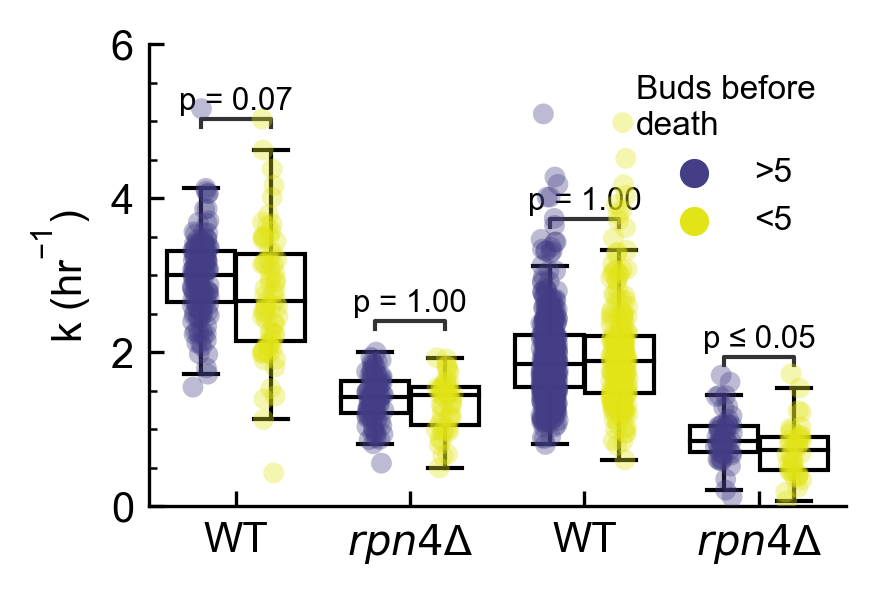

In [28]:
fits_df.loc[fits_df.compartment_name=='20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741_rfp', 'strain_name'] = 'JPC258_r'
from statannotations.Annotator import Annotator
strain_groups = [
    ['JPC258', 'JPC228'],
    ['JPC257'],
    ['JPC122'],
    ['JPC261'],
    ['JPC121', 'JPC146', 'JPC220'],
    ['JPC263'],
    ['JPC258_r']    
]
strain_groups = strain_groups[0:4]
strains = []
for group in strain_groups:
    for strain in group:
        strains.append(strain)

bg_substrates = [
    'WT-UBL',
    'rpn4d-UBL',
    'WT-ODC',
    'rpn4d-ODC',
    'WT-RKK',
    'rpn4d-RKK',
    'WT-DsRed'
]

bg_substrates = bg_substrates[0:4]

skip_comps = [
]

bound1 = 5
bound2 = 5
fits_df.loc[:, 'post-sep'] = np.nan
fits_df.loc[fits_df.dist_from_sen<bound1, 'post-sep'] = True
fits_df.loc[fits_df.dist_from_sen>bound2, 'post-sep'] = False
subdf = fits_df[fits_df.strain_name.isin(strains)]
subdf = subdf[~subdf.compartment_name.isin(skip_comps)]
for idx, strain_group in enumerate(strain_groups):
    subdf.loc[subdf.strain_name.isin(strain_group), 'background_substrate'] = bg_substrates[idx]

fig, ax = plotting.figure_ax(width_scale=1.5)
fig.set_dpi(300)

stripkwargs = {
    'x': 'background_substrate',
    'y': 'b',
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': bg_substrates,
    'ax': ax,
    'dodge': True,
    'data': subdf,
    'palette': pre_post_SEP_palette,
    'alpha': 0.35
}

boxkwargs = {
    'x': 'background_substrate',
    'y': 'b',
    'data': subdf,
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': bg_substrates,
    'ax': ax,
    'dodge': True,
    'palette': pre_post_SEP_palette,
    'showfliers': False
}
sns.boxplot(**boxkwargs, **plotting.transparent_boxes_prop_dict)

ax.set_xticklabels(bg_substrates)
ax.set_xlabel('')
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.legend(ax.get_legend_handles_labels()[0][2:4], ['>5 buds befored death', '<5 buds before death'],
          frameon=False,
          title='',
          bbox_to_anchor=(0.6, 1))

# plt.xticks(rotation=45)

# annotate t-test results
data=stripkwargs['data']
x = stripkwargs['x']
y = stripkwargs['y']
hue = stripkwargs['hue']
order = stripkwargs['order']
box_pairs=[
    (('WT-UBL', True), ("WT-UBL", False)),
    (('rpn4d-UBL', True), ("rpn4d-UBL", False)),
    (("WT-ODC", True), ("WT-ODC", False)),
    (("rpn4d-ODC", True), ("rpn4d-ODC", False)),
    (("WT-RKK", True), ("WT-RKK", False)),
    (("rpn4d-RKK", True), ("rpn4d-RKK", False)),
    (("WT-DsRed", True), ("WT-DsRed", False))
]

box_pairs = box_pairs[0:4]
test='Mann-Whitney'
text_format="simple"
loc="inside"

annotator = Annotator(ax, box_pairs, hue=hue, data=data, x=x, y=y, order=order,)
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1, fontsize=7.5,
                    comparisons_correction="bonferroni")
annotator.apply_and_annotate()

sns.stripplot(**stripkwargs)
ax.set_ylim(0, 6)
legend = ax.legend(ax.get_legend_handles_labels()[0][2:4], ['>5', '<5'], title='Buds before\ndeath', fontsize=8, frameon=False)
legend.get_title().set_fontsize(8)
ax.set_xticklabels(['WT', plotting.get_gene_deletion_string('rpn4'), 'WT', plotting.get_gene_deletion_string('rpn4')])
ax.set_xlabel('')
plotting.format_ticks(ax, add_minor_x=False, yminorspace=0.5)
filetype = '.svg'
strainnames = '-'.join(strains)
savepath = os.path.join(constants.byc_data_dir, f'meta/plots/fig2_{strainnames}_pre-post-SEP_summary{filetype}')
savepath = os.path.abspath(savepath)
fig.savefig(savepath)
print(f'Saved figure at \n{savepath}')

# Save subdf so it can be analyzed in R
subdf.to_csv(os.path.join(constants.byc_data_dir, 'subdf_wt_vs_rpn4_across_substrates.csv'), index=False)

## Degradation of RKK in WT and rpn4&Delta; and DsRed in WT

rpn4d-RKK_True vs. rpn4d-RKK_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.390e+02
WT-RKK_True vs. WT-RKK_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.177e-61 U_stat=4.231e+04
WT-DsRed_True vs. WT-DsRed_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.203e-09 U_stat=1.270e+02
Saved figure at 
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\fig2_JPC121-JPC146-JPC220-JPC263-JPC258_r_pre-post-SEP_summary.svg


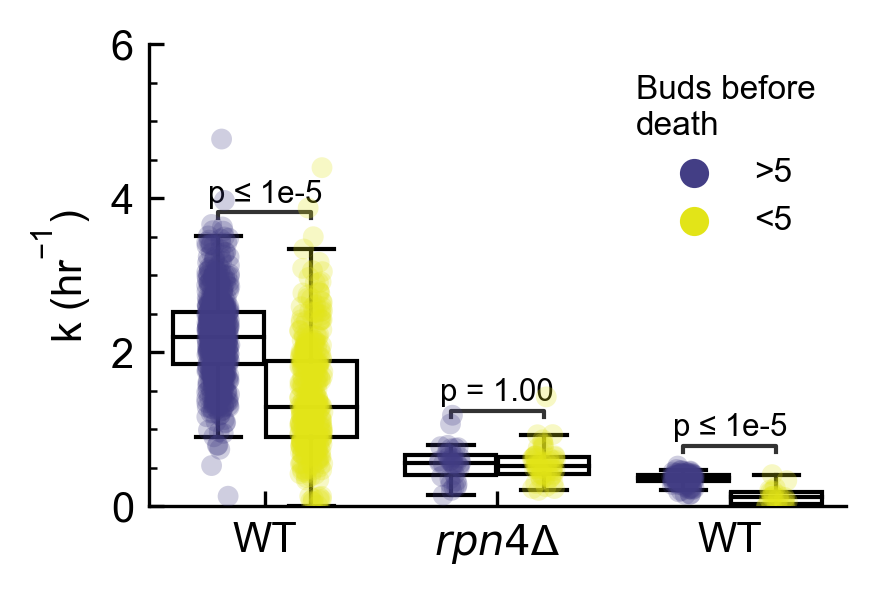

In [29]:
fits_df.loc[fits_df.compartment_name=='20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741_rfp', 'strain_name'] = 'JPC258_r'
from statannotations.Annotator import Annotator
range_to_plot = [4, 7]
strain_groups = [
    ['JPC258', 'JPC228'],
    ['JPC257'],
    ['JPC122'],
    ['JPC261'],
    ['JPC121', 'JPC146', 'JPC220'],
    ['JPC263'],
    ['JPC258_r']    
]
strain_groups = strain_groups[range_to_plot[0]:range_to_plot[1]]
strains = []
for group in strain_groups:
    for strain in group:
        strains.append(strain)

bg_substrates = [
    'WT-UBL',
    'rpn4d-UBL',
    'WT-ODC',
    'rpn4d-ODC',
    'WT-RKK',
    'rpn4d-RKK',
    'WT-DsRed'
]

bg_substrates = bg_substrates[range_to_plot[0]:range_to_plot[1]]

skip_comps = [
]

bound1 = 5
bound2 = 5
fits_df.loc[:, 'post-sep'] = np.nan
fits_df.loc[fits_df.dist_from_sen<bound1, 'post-sep'] = True
fits_df.loc[fits_df.dist_from_sen>bound2, 'post-sep'] = False
subdf = fits_df[fits_df.strain_name.isin(strains)]
subdf = subdf[~subdf.compartment_name.isin(skip_comps)]
for idx, strain_group in enumerate(strain_groups):
    subdf.loc[subdf.strain_name.isin(strain_group), 'background_substrate'] = bg_substrates[idx]

fig, ax = plotting.figure_ax(width_scale=1.5)
fig.set_dpi(300)

stripkwargs = {
    'x': 'background_substrate',
    'y': 'b',
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': bg_substrates,
    'ax': ax,
    'dodge': True,
    'data': subdf,
    'palette': pre_post_SEP_palette,
    'alpha': 0.25
}

boxkwargs = {
    'x': 'background_substrate',
    'y': 'b',
    'data': subdf,
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': bg_substrates,
    'ax': ax,
    'dodge': True,
    'palette': pre_post_SEP_palette,
    'showfliers': False
}
sns.boxplot(**boxkwargs, **plotting.transparent_boxes_prop_dict)

ax.set_xticklabels(bg_substrates)
ax.set_xlabel('')
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.legend(ax.get_legend_handles_labels()[0][2:4], ['>5 buds befored death', '<5 buds before death'],
          frameon=False,
          title='',
          bbox_to_anchor=(0.6, 1))

# plt.xticks(rotation=45)

# annotate t-test results
data=stripkwargs['data']
x = stripkwargs['x']
y = stripkwargs['y']
hue = stripkwargs['hue']
order = stripkwargs['order']
box_pairs=[
    (('WT-UBL', True), ("WT-UBL", False)),
    (('rpn4d-UBL', True), ("rpn4d-UBL", False)),
    (("WT-ODC", True), ("WT-ODC", False)),
    (("rpn4d-ODC", True), ("rpn4d-ODC", False)),
    (("WT-RKK", True), ("WT-RKK", False)),
    (("rpn4d-RKK", True), ("rpn4d-RKK", False)),
    (("WT-DsRed", True), ("WT-DsRed", False))
]

box_pairs = box_pairs[range_to_plot[0]:range_to_plot[1]]
test='Mann-Whitney'
text_format="simple"
loc="inside"

annotator = Annotator(ax, box_pairs, hue=hue, data=data, x=x, y=y, order=order,)
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1, fontsize=7.5,
                    comparisons_correction="bonferroni")
annotator.apply_and_annotate()

sns.stripplot(**stripkwargs)
ax.set_ylim(0, 6)
legend = ax.legend(ax.get_legend_handles_labels()[0][2:4], ['>5', '<5'], title='Buds before\ndeath', fontsize=8, frameon=False)
legend.get_title().set_fontsize(8)
ax.set_xticklabels(['WT', plotting.get_gene_deletion_string('rpn4'), 'WT'])
ax.set_xlabel('')
plotting.format_ticks(ax, add_minor_x=False, yminorspace=0.5)
filetype = '.svg'
strainnames = '-'.join(strains)
savepath = os.path.join(constants.byc_data_dir, f'meta/plots/fig2_{strainnames}_pre-post-SEP_summary{filetype}')
savepath = os.path.abspath(savepath)
fig.savefig(savepath)
print(f'Saved figure at \n{savepath}')

# Save subdf so it can be analyzed in R
subdf.to_csv(os.path.join(constants.byc_data_dir, 'subdf_wt_vs_rpn4_across_substrates.csv'), index=False)

## Degradation of RKK rpn4&Delta; and DsRed in WT

WT-DsRed_False vs. WT-DsRed_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.203e-09 U_stat=1.889e+03
rpn4d-RKK_False vs. rpn4d-RKK_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=9.460e+02
rpn4d-RKK_True vs. WT-DsRed_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:6.592e-11 U_stat=4.093e+03
Saved figure at 
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\fig2_JPC263-JPC258_r_pre-post-SEP_summary.svg


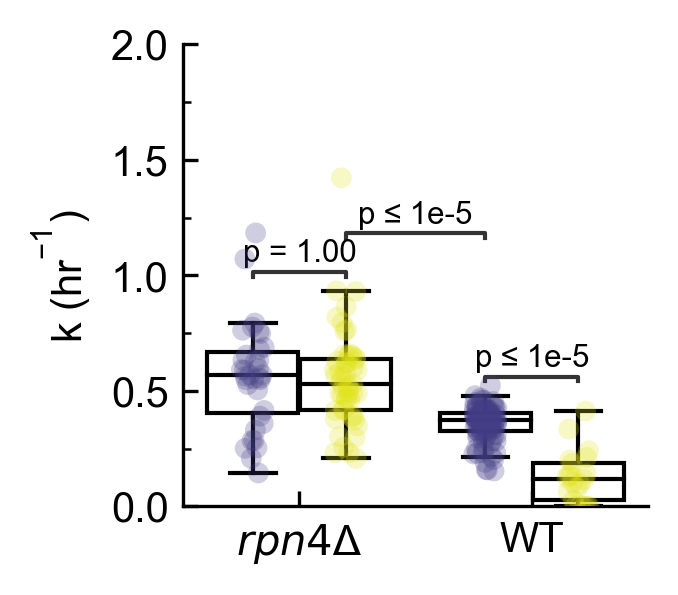

In [235]:
fits_df.loc[fits_df.compartment_name=='20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741_rfp', 'strain_name'] = 'JPC258_r'
from statannotations.Annotator import Annotator
range_to_plot = [5, 7]
strain_groups = [
    ['JPC258', 'JPC228'],
    ['JPC257'],
    ['JPC122'],
    ['JPC261'],
    ['JPC121', 'JPC146', 'JPC220'],
    ['JPC263'],
    ['JPC258_r']    
]
strain_groups = strain_groups[range_to_plot[0]:range_to_plot[1]]
strains = []
for group in strain_groups:
    for strain in group:
        strains.append(strain)

bg_substrates = [
    'WT-UBL',
    'rpn4d-UBL',
    'WT-ODC',
    'rpn4d-ODC',
    'WT-RKK',
    'rpn4d-RKK',
    'WT-DsRed'
]

bg_substrates = bg_substrates[range_to_plot[0]:range_to_plot[1]]

skip_comps = [
]

bound1 = 5
bound2 = 5
fits_df.loc[:, 'post-sep'] = np.nan
fits_df.loc[fits_df.dist_from_sen<bound1, 'post-sep'] = True
fits_df.loc[fits_df.dist_from_sen>bound2, 'post-sep'] = False
subdf = fits_df[fits_df.strain_name.isin(strains)]
subdf = subdf[~subdf.compartment_name.isin(skip_comps)]
for idx, strain_group in enumerate(strain_groups):
    subdf.loc[subdf.strain_name.isin(strain_group), 'background_substrate'] = bg_substrates[idx]

fig, ax = plotting.figure_ax(width_scale=1)
fig.set_dpi(300)

stripkwargs = {
    'x': 'background_substrate',
    'y': 'b',
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': bg_substrates,
    'ax': ax,
    'dodge': True,
    'data': subdf,
    'palette': pre_post_SEP_palette,
    'alpha': 0.25
}

boxkwargs = {
    'x': 'background_substrate',
    'y': 'b',
    'data': subdf,
    'hue': 'post-sep',
    'hue_order': [False, True],
    'order': bg_substrates,
    'ax': ax,
    'dodge': True,
    'palette': pre_post_SEP_palette,
    'showfliers': False
}
sns.boxplot(**boxkwargs, **plotting.transparent_boxes_prop_dict)

ax.set_xticklabels(bg_substrates)
ax.set_xlabel('')
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.legend(ax.get_legend_handles_labels()[0][2:4], ['>5 buds befored death', '<5 buds before death'],
          frameon=False,
          title='',
          bbox_to_anchor=(0.6, 1))

# plt.xticks(rotation=45)

# annotate t-test results
data=stripkwargs['data']
x = stripkwargs['x']
y = stripkwargs['y']
hue = stripkwargs['hue']
order = stripkwargs['order']
box_pairs=[
    (("rpn4d-RKK", True), ("rpn4d-RKK", False)),
    (("WT-DsRed", True), ("WT-DsRed", False)),
    (("rpn4d-RKK", True), ("WT-DsRed", False))
]

# box_pairs = box_pairs[range_to_plot[0]:range_to_plot[1]]
test='Mann-Whitney'
text_format="simple"
loc="inside"

annotator = Annotator(ax, box_pairs, hue=hue, data=data, x=x, y=y, order=order,)
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1, fontsize=7.5,
                    comparisons_correction="bonferroni")
annotator.apply_and_annotate()

sns.stripplot(**stripkwargs)
ax.set_ylim(0, 2)
ax.legend(ax.get_legend_handles_labels()[0][2:4], ['>5', '<5'], title='Buds before\ndeath', fontsize=8, frameon=False)
ax.legend_.set_visible(False)
ax.set_xticklabels([plotting.get_gene_deletion_string('rpn4'), 'WT'])
ax.set_xlabel('')
plotting.format_ticks(ax, add_minor_x=False, yminorspace=0.25)
filetype = '.svg'
strainnames = '-'.join(strains)
savepath = os.path.join(constants.byc_data_dir, f'meta/plots/fig2_{strainnames}_pre-post-SEP_summary{filetype}')
savepath = os.path.abspath(savepath)
fig.savefig(savepath)
print(f'Saved figure at \n{savepath}')

# Save subdf so it can be analyzed in R
subdf.to_csv(os.path.join(constants.byc_data_dir, 'subdf_wt_vs_rpn4_across_substrates.csv'), index=False)

## Multiple measurements in the same cell analysis

### Get the subset of data

In [159]:
strains = ['JPC121', 'JPC146', 'JPC220']
# strains = ['JPC122']
# strains = ['JPC258', 'JPC228']
# strains = ['JPC199']
# strains = ['JPC193']
# strains = ['JPC262']
# strains = ['JPC136']

skip_comps = [
     '20221104_byc_JPC136_R-YFP-Su9_UBR1-OE',
     '20230201_byc_JPC228-20230127-int_UBL-YFP-Su9x3_BY4741_rfp'
]

pre_load_vortex = False
blue_light_exposed = False

sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]
# sub_fits_df = sub_fits_df[sub_fits_df['tet_stock_concn']=='1000X']
# sub_fits_df = sub_fits_df[sub_fits_df['pre-load-vortex']==pre_load_vortex]
# sub_fits_df = sub_fits_df[sub_fits_df['potential_blue_light_exposure_during_filter_cube_switching']==blue_light_exposed]
sub_fits_df = sub_fits_df[sub_fits_df.dist_from_sen>=0]
sub_fits_df = sub_fits_df[~sub_fits_df.b.isna()]
sub_fits_df = sub_fits_df[~sub_fits_df.compartment_name.isin(skip_comps)]
sub_bud_df = buds_df[buds_df.strain_name.isin(strains)]
# sub_bud_df = sub_bud_df[sub_bud_df['tet_stock_concn']=='1000X']
# sub_bud_df = sub_bud_df[sub_bud_df['pre-load-vortex']==pre_load_vortex]
# sub_bud_df = sub_bud_df[sub_bud_df['potential_blue_light_exposure_during_filter_cube_switching']==blue_light_exposed]
sub_bud_df = sub_bud_df[~sub_bud_df.compartment_name.isin(skip_comps)]
ratecolor = strains_color_dict[strains[0]]

database.set_bud_id(sub_fits_df)

### Plot "vectors" with a line for each cell

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_y=b_hue=bud_id_alpha=0.12_linewidth=1.svg


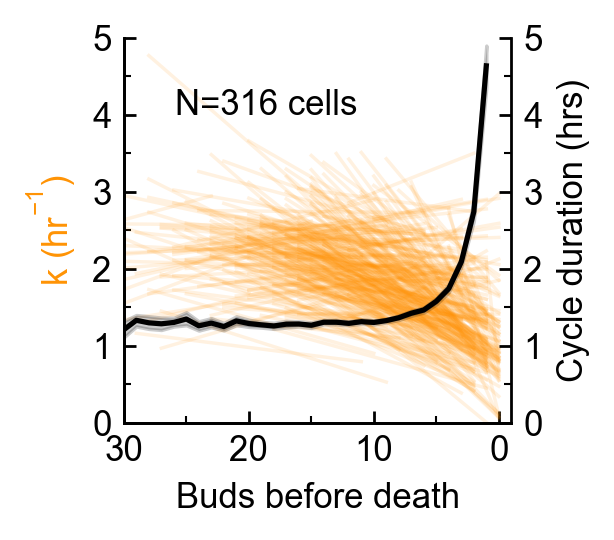

In [160]:
fig, ax = plotting.figure_ax()

xlim = (30, -1)
xticks = np.arange(0, xlim[0]+0.1, 10)
ylim = (0, 5)
yticks = np.arange(ylim[0], ylim[1]+0.1, 1)
kwargs = {
    'x': 'dist_from_sen',
    'y': 'b',
    'hue': 'bud_id',
    'data': sub_fits_df,
    'ax': ax,
    'alpha': 0.12,
    'linewidth': 1,
    'palette': [ratecolor for i in range(len(sub_fits_df.bud_id.unique()))]
}
# Plot data
sns.lineplot(**kwargs)
# Plot cycle duration
ax2 = ax.twinx()
kwargs2 = {
    'x': 'dist_from_sen',
    'y': 'cycle_duration_hrs',
    'data': sub_bud_df,
    'ax': ax2,
    'color': 'black'
}
sns.lineplot(**kwargs2)
# Plot aesthetics
plotting.format_ticks(ax2)
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0, 5)
ax.set_ylim(0, 3)
plotting.format_ticks(ax)
ax.set_ylabel((r'$k_{chase2}$/$k_{chase1}$'), color=ratecolor)
ax.set_xlabel('Buds before death\n(chase 2)')
ax2.set_ylabel('Cycle duration (hrs)')
# Formatting
ax.legend_.set_visible(False)
ax.set_xlim(xlim)
ax.set_xticks(xticks)
ax.set_ylim(ylim)
ax.set_yticks(yticks)
plotting.format_ticks(ax)
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs, color=ratecolor)
ax.set_xlabel('Buds before death')
table = sub_fits_df.loc[:, ['bud_id', 'dist_from_sen', 'b']].pivot_table(index=['bud_id'], aggfunc='count').reset_index()
n_val = len(table[table.b==2].bud_id.unique())
ax.annotate(f'N={n_val} cells', xy=(0.35, 0.85), xycoords='figure fraction')
# Save figure
plotting.save_figure(fig, kwargs, ext='.svg')

### Calculate and plot fold changes between chase 1 and 2

In [161]:
multimeasure_bud_ids = [bud_id for bud_id in sub_fits_df.bud_id.unique() if len(sub_fits_df.loc[sub_fits_df.bud_id==bud_id, :])==2]
multimeasuredf = sub_fits_df[sub_fits_df.bud_id.isin(multimeasure_bud_ids)]

chase1_df = multimeasuredf[multimeasuredf.abs_chase_frame<100]
chase2_df = multimeasuredf[multimeasuredf.abs_chase_frame>100]

for df in [chase1_df, chase2_df]:
    df.sort_values(by='bud_id', ascending=True, inplace=True)
    if 'level_0' in df.columns:
        df.drop(columns='level_0', inplace=True, axis=1)
    df.reset_index(inplace=True)
    if 'level_0' in df.columns:
        df.drop(columns='level_0', inplace=True, axis=1)    
# We should have perfectly paired chases for same cell when
# young and old
chasedf = pd.merge(chase1_df, chase2_df, on='bud_id', suffixes=('_chase1', '_chase2'))
chasedf.loc[:, 'b_chase1_over_b_chase2'] = chasedf.b_chase1/chasedf.b_chase2
chasedf.loc[:, 'b_chase2_over_b_chase1'] = chasedf.b_chase2/chasedf.b_chase1

C:\Users\johnp\AppData\Local\Temp\ipykernel_668\100309678.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='bud_id', ascending=True, inplace=True)
C:\Users\johnp\AppData\Local\Temp\ipykernel_668\100309678.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns='level_0', inplace=True, axis=1)
C:\Users\johnp\AppData\Local\Temp\ipykernel_668\100309678.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

Text(0.5, 0, 'Buds before death (chase 2)')

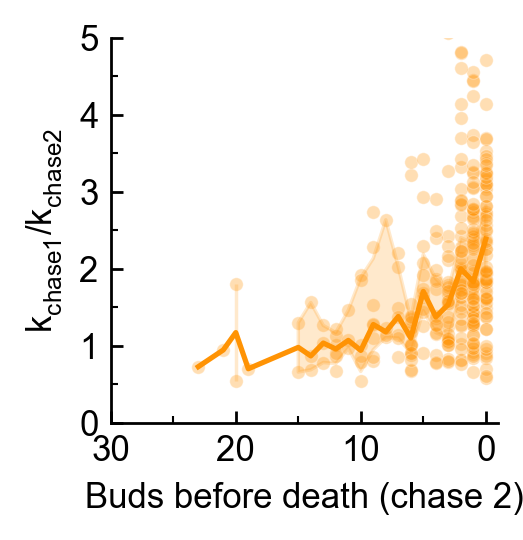

In [162]:
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'dist_from_sen_chase2',
    'y': 'b_chase1_over_b_chase2',
    'data': chasedf,
    'ax': ax,
    'color': ratecolor,
}

sns.scatterplot(**kwargs, s=15, alpha=0.3)
sns.lineplot(**kwargs, estimator='median')
# sns.boxplot(**kwargs)

ax.set_ylim(0, 5)
ax.set_xlim(30, -1)
ax.set_xticks(np.arange(0, ax.get_xlim()[0]+0.1, 10))
plotting.format_ticks(ax)

ax.set_ylabel((r'$k_{chase1}$/$k_{chase2}$'))
ax.set_xlabel('Buds before death (chase 2)')

### Bar graphs with 95% CI

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_chase2_y=b_chase2_over_b_chase1.svg


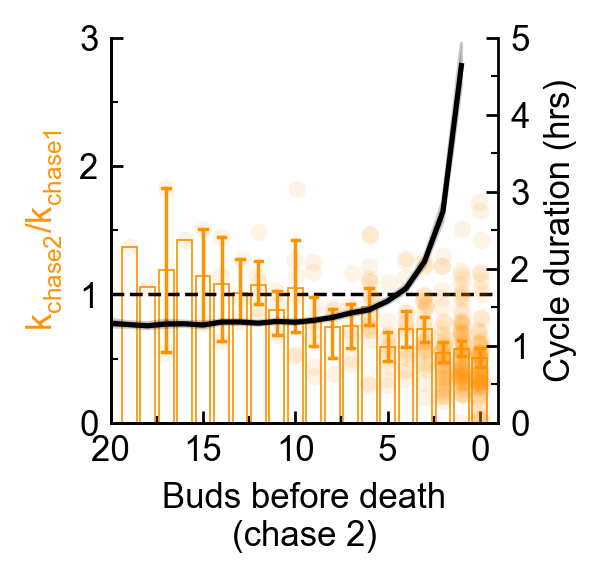

In [163]:
fig, ax = plotting.figure_ax()
ax.axhline(1, color='black', linewidth=1, linestyle='--')
# Don't want cells where both measurements were made after SEP
bools = (chasedf.dist_from_sen_chase1>5)

kwargs = {
    'x': 'dist_from_sen_chase2',
    'y': 'b_chase2_over_b_chase1',
    'data': chasedf[bools],
    'ax': ax,
}
sns.stripplot(**kwargs, alpha=0.1, color=ratecolor)
sns.barplot(
    **kwargs,
    color='white',
    edgecolor=ratecolor,
    linewidth=0.5,
    errorbar=('ci', 95),
    errcolor=ratecolor,
    errwidth=1,
    capsize=0.4
)
# Plot cycle duration
ax2 = ax.twinx()
kwargs2 = {
    'x': 'dist_from_sen',
    'y': 'cycle_duration_hrs',
    'data': sub_bud_df,
    'ax': ax2,
    'color': 'black'
}
sns.lineplot(**kwargs2)
# Plot aesthetics
plotting.format_ticks(ax2)
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0, 5)
ax.set_ylim(0, 3)
ax.set_xlim(16, -1)
xticks = [int(val) for val in np.arange(0, 21, 5)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
plotting.format_ticks(ax)
ax.set_ylabel((r'$k_{chase2}$/$k_{chase1}$'), color=ratecolor)
ax.set_xlabel('Buds before death\n(chase 2)')
ax2.set_ylabel('Cycle duration (hrs)')
# for patch in ax.patches:
#     patch.set_facecolor('white')
plotting.save_figure(fig, kwargs, ext='.svg')

### Strip plots of fold change chase2/chase1 vs. after SEP for chase chase 2

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.570e-13 U_stat=1.202e+04
Fold change young over old=1.641998897532472
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=post_sep_y=b_chase2_over_b_chase1_color=(1.0, 0.5764705882352941, 0.01568627450980392).svg


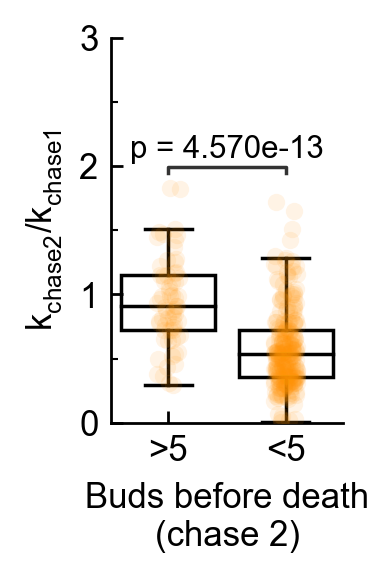

In [164]:
fig, ax = plotting.figure_ax(width_scale=0.6)
chasedf.loc[chasedf.dist_from_sen_chase2>5, 'post_sep'] = False
chasedf.loc[chasedf.dist_from_sen_chase2<5, 'post_sep'] = True
# Don't want to compare cells where both chases were done post-sep
bools = (chasedf.dist_from_sen_chase1>5)
kwargs = {
    'x': 'post_sep',
    'y': 'b_chase2_over_b_chase1',
    'data': chasedf[bools],
    'ax': ax,
    'color': ratecolor
}

sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict, showfliers=False)
sns.stripplot(**kwargs, alpha=0.1)
# annotate t-test results
data=kwargs['data']
x = kwargs['x']
y = kwargs['y']
box_pairs=[
    (True, False)
]
test='Mann-Whitney'
text_format="full"
loc="inside"
annotator = Annotator(ax, box_pairs, data=data, x=x, y=y, )
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1, fontsize=9, line_offset_to_group=0)
annotator.apply_and_annotate()

# sns.stripplot(**kwargs, alpha=0.1)
ax.set_ylim(0, 3)
ax.set_yticks(np.arange(0, ax.get_ylim()[1]+0.01, 1))
# ax.set_yscale('log', base=2)
ax.set_ylabel((r'$k_{chase2}$/$k_{chase1}$'))
ax.set_xticklabels(['>5', '<5'])
ax.set_xlabel('Buds before death\n(chase 2)')
fold_change = chasedf.loc[chasedf.post_sep==False, 'b_chase2_over_b_chase1'].mean()/chasedf.loc[chasedf.post_sep==True, 'b_chase2_over_b_chase1'].mean()
print(f'Fold change young over old={fold_change}')
plotting.format_ticks(ax, add_minor_x=False)
plotting.save_figure(fig, kwargs, ext='.svg')

### Histogram of end of life k2/k1

Text(0.5, 1.0, 'Cells <5 buds\nbuds before death\n(at chase2)')

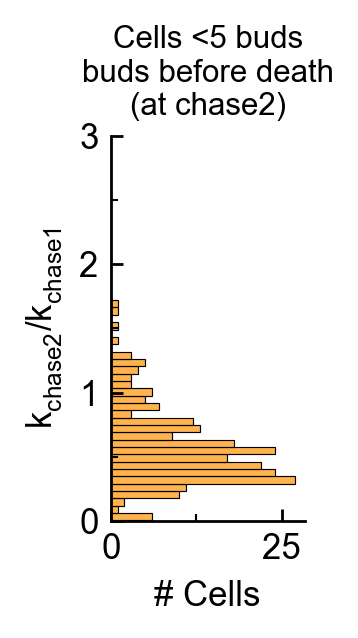

In [170]:
fig, ax = plotting.figure_ax(width_scale=0.5)

kwargs = {
    'y': 'b_chase2_over_b_chase1',
    'data': chasedf[chasedf.dist_from_sen_chase2<5],
    'ax': ax,
    'hue_order': [False, True],
    'bins': 30,
    'color': ratecolor,
    'alpha': 0.7,
    'kde': False
}

sns.histplot(**kwargs)

ax.set_ylim(0, 6)
ax.set_yticks(np.arange(0, np.max(ax.get_ylim())+0.1, 1))
ax.set_ylim(0, 3)
ax.set_yticks(np.arange(0, ax.get_ylim()[1]+0.01, 1))
# ax.set_yscale('log', base=2)
ax.set_ylabel((r'$k_{chase2}$/$k_{chase1}$'))
ax.set_xlabel('# Cells')
plotting.format_ticks(ax)
ax.set_title('Cells <5 buds\nbuds before death\n(at chase2)', fontsize=9)

### Scatter plot of correlation between chases

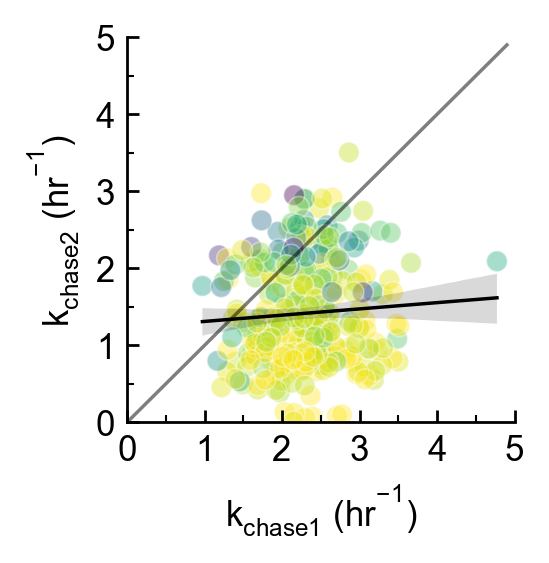

In [185]:
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'b_chase1',
    'y': 'b_chase2',
    'hue': 'dist_from_sen_chase2',
    'data': chasedf[chasedf.dist_from_sen_chase2>-1],
    'palette': 'viridis_r',
    'ax': ax,
    'alpha': 0.4
}
ax.plot(np.arange(0, 5, 0.1), fitting_tools.line(np.arange(0, 5, 0.1), 1, 0),
        color='black', linewidth=1, alpha=.5)
sns.scatterplot(**kwargs)
sns.regplot(x=kwargs['x'], y=kwargs['y'], data=kwargs['data'], color='black', scatter=False, line_kws={'linewidth': 1})

ax.legend_.set_visible(False)
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.set_ylabel(r'$k_{chase2}$' + plotting.annoying_strings().k_inverse_hrs[1:])
ax.set_xlabel(r'$k_{chase1}$' + plotting.annoying_strings().k_inverse_hrs[1:])
ax.set_xticks(np.arange(0, np.max(ax.get_xlim())+0.1, 1))
plotting.format_ticks(ax)

## Tracking individual cell fate

### Annotating cycle duration at chase etc.

In [51]:
strains = ['JPC121', 'JPC220', 'JPC146']
tet_stock_concn = '1000X'
sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]
sub_fits_df = sub_fits_df[sub_fits_df.tet_stock_concn==tet_stock_concn]
sub_fits_df = sub_fits_df[sub_fits_df.dist_from_sen>=0]

sub_buds_df = buds_df[buds_df.strain_name.isin(strains)]
sub_buds_df = sub_buds_df[sub_buds_df.tet_stock_concn==tet_stock_concn]
sub_buds_df = sub_buds_df[sub_buds_df.dist_from_sen>=0]

database.set_bud_id(sub_buds_df)
database.set_bud_id(sub_fits_df)

collection_interval_mins = 10
sub_fits_df.loc[:, 'measdex'] = sub_fits_df.compartment_name.str.cat(sub_fits_df.cell_index.astype(int).astype(str), sep='-')
unique_measdices = sub_fits_df.measdex.unique()
i=1
for measdex in unique_measdices:
    print(f'Measuring cell chase {i} of {len(unique_measdices)}', end='\r')
    measdex_bool = sub_fits_df.measdex==measdex
    cell_index = int(sub_fits_df.loc[measdex_bool, 'cell_index'].iloc[0])
    # Use the cell's crop ROI dataframe .csv file to annotate whether
    # the cell contains an aggregate at the time the chase performed
    compdir = sub_fits_df.loc[measdex_bool, 'compartment_dir'].iloc[0]
    crop_roi_df = database.get_crop_roi_df_from_cell_index_compdir(cell_index, compdir)
    if 'contains_aggregate' in crop_roi_df.columns:
        contains_aggregate = crop_roi_df.contains_aggregate.iloc[0]
    else:
        contains_aggregate = np.nan
    sub_fits_df.loc[measdex_bool, 'contains_aggregate'] = contains_aggregate
    abs_chase_frame = sub_fits_df[measdex_bool].abs_chase_frame.iloc[0]
    # Read in and analyze the bud_rois_df
    bud_rois_zip_path = sub_fits_df[measdex_bool].bud_roi_set_path.iloc[0]
    cell_buds_df = files.read_rectangular_rois_as_df(bud_rois_zip_path)
    cell_buds_df.sort_values(by='position', ascending=True, inplace=True)
    cell_buds_df.reset_index(inplace=True)
    # Last frame is the death frame so it's not included in cycle duration measurements
    cell_buds_df.loc[:cell_buds_df.index.max()-2, 'cycle_duration_frames'] = np.diff(cell_buds_df.position[0:-1])
    cell_buds_df.loc[:, 'cycle_duration_hrs'] = (cell_buds_df.cycle_duration_frames*collection_interval_mins)/60
    cell_buds_df.loc[:, 'frame'] = cell_buds_df.position - 1
    cell_buds_df.loc[:, 'cycle_number'] = cell_buds_df.index
    database.annotate_daughter_shapes(cell_buds_df)
    n_long_daughters = len(cell_buds_df[cell_buds_df.bud_shape=='long'])
    n_round_daughters = len(cell_buds_df[cell_buds_df.bud_shape=='round'])
    # Annotate the last frame at which the cell was seen alive
    # and get rid of it from the data
    cell_buds_df.loc[:, 'death_frame'] = cell_buds_df.frame.max()
    cell_buds_df = cell_buds_df.loc[0:cell_buds_df.index.max()-1, :]
    deltas = abs_chase_frame - cell_buds_df.frame
    # Ideally we want the cell cycle that's occuring during the chase
    # so we first try selecting those that start before or at the chase
    # frame
    positive_deltas = deltas[deltas>=0]
    if len(positive_deltas) > 0:
        cycle_number_closest_chase = np.argmin(positive_deltas)
    # if we can't find a cell cycle starting before or after the chase
    # (probably the case in a lot of t0 chases) we choose the cell 
    # cycle that starts closest to the chase
    else:
        abs_deltas = np.abs(deltas)
        cycle_number_closest_chase = np.argmin(abs_deltas)

    cycle_duration_at_chase = cell_buds_df.loc[cycle_number_closest_chase, 'cycle_duration_hrs']
    if np.isnan(cycle_duration_at_chase):
        try:
            # print(f'Closest cycle duration could not be calculated, using the one before')
            cycle_number_second_closest_to_chase = cycle_number_closest_chase-1
            cycle_duration_at_chase = cell_buds_df.loc[cycle_number_second_closest_to_chase, 'cycle_duration_hrs']
        except:
            pass
    sub_fits_df.loc[measdex_bool, 'cycle_duration_at_chase'] = cycle_duration_at_chase
    sub_fits_df.loc[measdex_bool, 'rls'] = len(cell_buds_df)
    sub_fits_df.loc[measdex_bool, 'n_long_daughters'] = n_long_daughters
    sub_fits_df.loc[measdex_bool, 'n_round_daughters'] = n_round_daughters
    # Only consider a cell's age at chase to be observed if the cell's
    # bud production started being observed in the first 3 hours of the expt
    if sub_fits_df.frame.min() < 19:
        sub_fits_df.loc[measdex_bool, 'age_at_chase'] = len(cell_buds_df[cell_buds_df.frame<=abs_chase_frame])
        sub_fits_df.loc[measdex_bool, 'rls_observed'] = True
    else:
        sub_fits_df.loc[measdex_bool, 'age_at_chase'] = np.nan
        sub_fits_df.loc[measdex_bool, 'rls_observed'] = False
    last_bud_hours = (cell_buds_df.frame.max()*collection_interval_mins)/60
    abs_chase_hours = (abs_chase_frame*collection_interval_mins)/60
    sub_fits_df.loc[measdex_bool, 'hours_after_last_bud'] = abs_chase_hours - last_bud_hours

    i+=1

sep_border = 5
sub_fits_df.loc[sub_fits_df.dist_from_sen<sep_border, 'post_sep'] = True
sub_fits_df.loc[sub_fits_df.dist_from_sen>sep_border, 'post_sep'] = False
n_long_thresh = 1
sub_fits_df.loc[sub_fits_df.n_long_daughters>=n_long_thresh, 'produced_elongated_daughters'] = True
sub_fits_df.loc[sub_fits_df.n_long_daughters==0, 'produced_elongated_daughters'] = False
sub_fits_df.loc[sub_fits_df.dist_from_sen>5, 'post_sep'] = False
sub_fits_df.loc[sub_fits_df.dist_from_sen<5, 'post_sep'] = True

names = '-'.join(strains)
savepath = os.path.abspath(os.path.join(constants.byc_data_dir, f'meta/{names}_sub_fits_df_cell_cycle_annotated.csv'))
sub_fits_df.to_csv(savepath, index=False)
print(f'Saved cell cycle annotated data at\n{savepath}')

Saved cell cycle annotated data at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121-JPC220-JPC146_sub_fits_df_cell_cycle_annotated.csv


Use the aggregate presence and aging mode classification from above to annotate the `buds_df` data

In [59]:
for bud_id in sub_buds_df.bud_id.unique():
    fits_df_slice = sub_fits_df[sub_fits_df.bud_id==bud_id]
    # Annotate the buds_df
    # aging mode data here will be the same for both measurements
    # in the fits_df because the data are derived from the bud roi set
    # for the cell in both those measurements
    sub_buds_df.loc[sub_buds_df.bud_id==bud_id, 'produced_elongated_daughters'] = fits_df_slice.produced_elongated_daughters.values[0]
    sub_buds_df.loc[sub_buds_df.bud_id==bud_id, 'n_long_daughters'] = fits_df_slice.n_long_daughters.values[0]
    # Whether the cell contains an aggregate at chase
    # is only accurately annotated in crop roi sets, so if there were multiple
    # measurements for a single cell, consider it to contain an aggregate in 
    # the buds df if there was an aggregate in one of those measurements
    if len(fits_df_slice)==1:
        sub_buds_df.loc[sub_buds_df.bud_id==bud_id, 'contains_aggregate'] = fits_df_slice.contains_aggregate.values[0]
    else:
        # If there are multiple measurements from the same cell, then if
        # there was an aggregate present at one of those measurements, 
        # annotate that in buds_df
        contains_aggregate_list = fits_df_slice.contains_aggregate.values
        if 'yes' in contains_aggregate_list:
            contains_aggregate = 'yes'
        elif np.nan in list(contains_aggregate_list):
            contains_aggregate = np.nan
        else:
            contains_aggregate = 'no'
        sub_buds_df.loc[sub_buds_df.bud_id==bud_id, 'contains_aggregate'] = contains_aggregate
        
sub_buds_df.loc[sub_buds_df.first_bud_frame<=18, 'observed_since_start'] = True
sub_buds_df.loc[sub_buds_df.first_bud_frame>18, 'observed_since_start'] = False

names = '-'.join(strains)
savepath = os.path.abspath(os.path.join(constants.byc_data_dir, f'meta/{names}_sub_buds_df_cell_cycle_annotated.csv'))
sub_buds_df.to_csv(savepath, index=False)
print(f'Saved cell cycle annotated data at\n{savepath}')

Saved cell cycle annotated data at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121-JPC220-JPC146_sub_buds_df_cell_cycle_annotated.csv


### Read in annotated data from above

In [60]:
path = r"C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121-JPC220-JPC146_sub_fits_df_cell_cycle_annotated.csv"
path2 = r"C:\Users\johnp\Dropbox\Projects\byc\data\meta\JPC121-JPC220-JPC146_sub_buds_df_cell_cycle_annotated.csv"
sub_fits_df = pd.read_csv(path)
sub_buds_df = pd.read_csv(path2)

C:\Users\johnp\AppData\Local\Temp\ipykernel_11592\775205871.py:4: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_buds_df = pd.read_csv(path2)


### k vs. dist from sen in mode 1 and mode 2

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_y=cycle_duration_hrs_hue=produced_elongated_daughters_linestyle=--.svg


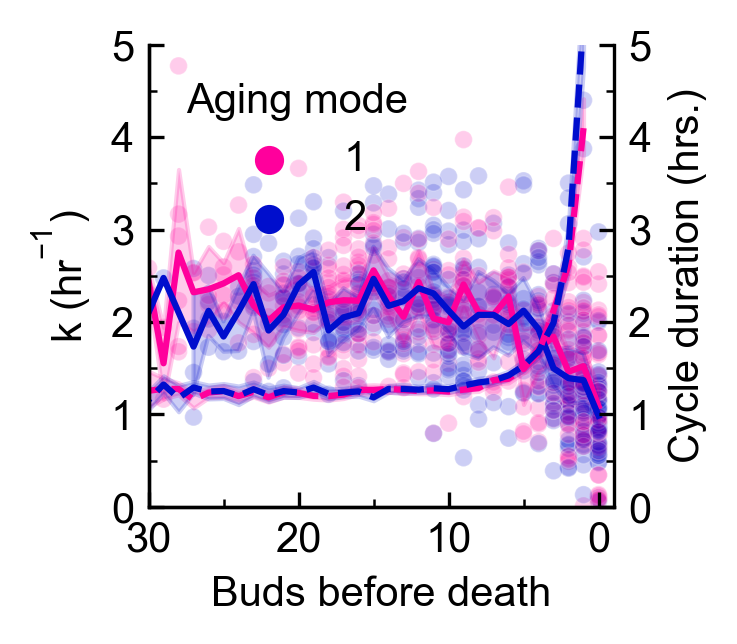

In [55]:
fig, ax = plotting.figure_ax()
fig.set_dpi(300)

kwargs = {
    'x': 'dist_from_sen',
    'y': 'b',
    'hue': 'produced_elongated_daughters',
    'ax': ax,
    'data': sub_fits_df,
    'palette': [other_colors['mode1'], other_colors['mode2']],
    'hue_order': [True, False],
}

sns.scatterplot(**kwargs, alpha=0.2, size=15)
sns.lineplot(**kwargs, alpha=1)
ax.set_xlim(30, -1)
ax.set_xticks(np.arange(0, ax.get_xlim()[0]+0.1, 10))
ax.set_ylim(0, 5)
ax.set_yticks(np.arange(0, ax.get_ylim()[1]+0.1, 1))
# plotting.legend_outside()
ax.set_xlabel('Buds before death')
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)

# Plot cycle duration
ax2 = ax.twinx()
kwargs = {
    'x': 'dist_from_sen',
    'y': 'cycle_duration_hrs',
    'hue': 'produced_elongated_daughters',
    'data': sub_buds_df,
    'hue_order': [True, False],
    'ax': ax,
    'palette': [other_colors['mode1'], other_colors['mode2']],
    'linestyle': '--'
}

sns.lineplot(**kwargs)
ax2.set_ylim(0, 5)
ax2.set_yticks(np.arange(0, np.max(ax.get_ylim())+0.1, 1))
ax2.set_ylabel('Cycle duration (hrs.)')
plotting.format_ticks(ax)
ax.legend(ax.get_legend_handles_labels()[0], ['1', '2'], frameon=False, title='Aging mode')

plotting.format_ticks(ax)
plotting.format_ticks(ax2)
ax2.spines['top'].set_visible(False)
plotting.save_figure(fig, kwargs, ext='.svg')

### Strip plot k vs pre/post SEP vs. aging mode

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False_False vs. False_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.982e-30 U_stat=3.259e+04
True_False vs. True_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.870e-27 U_stat=3.374e+04
True_False vs. False_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.581e-01 U_stat=3.395e+04
True_True vs. False_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.682e-02 U_stat=1.452e+04


Text(0.5, -17.833333333333353, 'Mode')

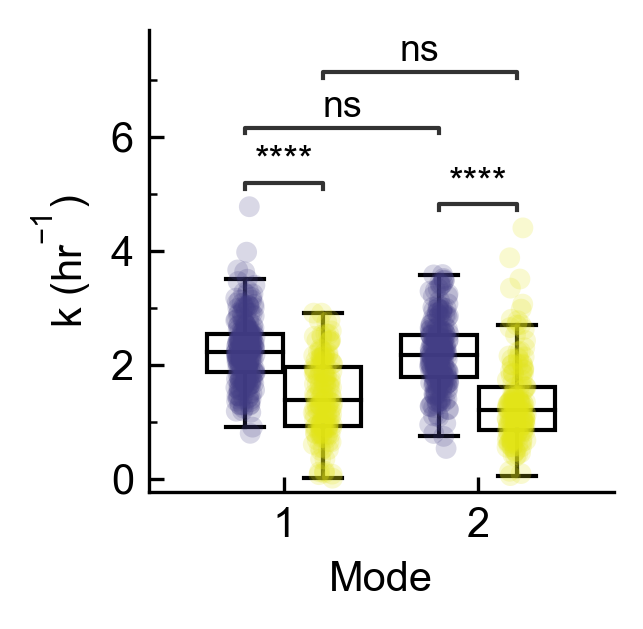

In [46]:
fig, ax = plotting.figure_ax(width_scale=1)
fig.set_dpi(300)

sub_fits_df.loc[sub_fits_df.dist_from_sen<5, 'post_sep'] = True
sub_fits_df.loc[sub_fits_df.dist_from_sen>5, 'post_sep'] = False

# ax.set_ylim(0, 4)

kwargs = {
    'x': 'produced_elongated_daughters',
    'y': 'b',
    'hue': 'post_sep',
    'ax': ax,
    'data': sub_fits_df[sub_fits_df.b<=5],
    'palette': plotting.get_pre_post_sep_palette(),
    'hue_order': [False, True],
    'dodge': True,
    'order': [True, False]
}
# Plot stuff
sns.stripplot(**kwargs, alpha=0.2)
sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict,
           showfliers=False)
# annotate t-test results
data=kwargs['data']
x = kwargs['x']
y = kwargs['y']
hue = kwargs['hue']
order = kwargs['order']
box_pairs=[
    ((True, True), (True, False)),
    ((False, True), (False, False)),
    ((True, False), (False, False)),
    ((True, True), (False, True))
]
test='Mann-Whitney'
text_format="full"
text_format='star'
loc="inside"
annotator = Annotator(ax, box_pairs, hue=hue, data=data, x=x, y=y, order=order,)
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1, fontsize=9,
                   comparisons_correction="bonferroni",
                   line_offset_to_group=5, line_offset=30)
annotator.apply_and_annotate()


ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)

ax.legend(
    ax.get_legend_handles_labels()[0][0:2],
    ['>5', '<5'],
    title='Buds before\ndeath',
    frameon=False,
    fontsize=8
)
ax.legend_.set_visible(False)
plotting.format_ticks(ax, add_minor_x=False)
ax.set_xticklabels(['1', '2'])
ax.set_xlabel('Mode')
# ax.set_ylim(0, 5)

### Cycle duration vs. dist from sen vs. aging mode

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_y=cycle_duration_hrs_hue=produced_elongated_daughters.svg


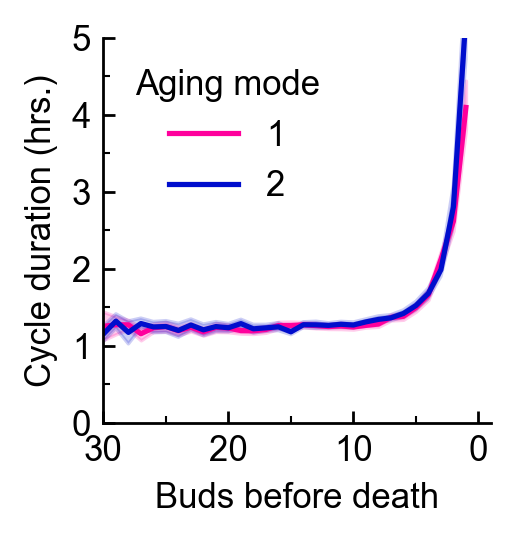

In [474]:
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'dist_from_sen',
    'y': 'cycle_duration_hrs',
    'hue': 'produced_elongated_daughters',
    'data': sub_buds_df,
    'hue_order': [True, False],
    'ax': ax,
    'palette': [other_colors['mode1'], other_colors['mode2']]
}

sns.lineplot(**kwargs)

ax.set_xlim(30, -1)
ax.set_xticks(np.arange(0, np.max(ax.get_xlim())+0.1, 10))
ax.set_ylim(0, 5)
ax.set_yticks(np.arange(0, np.max(ax.get_ylim())+0.1, 1))
ax.legend(ax.get_legend_handles_labels()[0], ['1', '2'], frameon=False, title='Aging mode')
ax.set_xlabel('Buds before death')
ax.set_ylabel('Cycle duration (hrs.)')
plotting.format_ticks(ax)
plotting.save_figure(fig, kwargs, ext='.svg')

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=cycle_number_y=cycle_duration_hrs_hue=produced_elongated_daughters.png


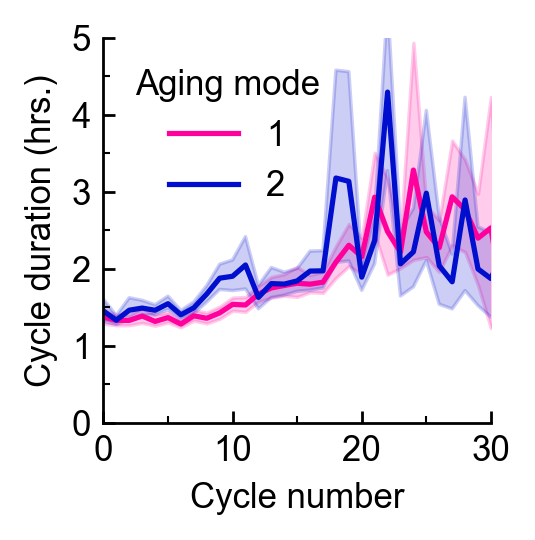

In [298]:
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'cycle_number',
    'y': 'cycle_duration_hrs',
    'hue': 'produced_elongated_daughters',
    'data': sub_buds_df,
    'hue_order': [True, False],
    'ax': ax,
    'palette': [other_colors['mode1'], other_colors['mode2']]
}

sns.lineplot(**kwargs)

ax.set_xlim(0, 30)
ax.set_xticks(np.arange(0, np.max(ax.get_xlim())+0.1, 10))
ax.set_ylim(0, 5)
ax.set_yticks(np.arange(0, np.max(ax.get_ylim())+0.1, 1))
ax.legend(ax.get_legend_handles_labels()[0], ['1', '2'], frameon=False, title='Aging mode')
ax.set_xlabel('Cycle number')
ax.set_ylabel('Cycle duration (hrs.)')
plotting.format_ticks(ax)
plotting.save_figure(fig, kwargs)

### Number of cells per aging mode

In [75]:
aggdex = [
    'produced_elongated_daughters',
    'contains_aggregate',
    'rls_observed',
    'bud_id',
    'end_event_type',
    'rls_suitable',
    'potential_blue_light_exposure_during_filter_cube_switching',
    'pre-load-vortex',
    'pre-load-spin'
]
wanted_cols = [col for col in sub_fits_df.columns if sub_fits_df[col].dtype != 'O']
cols_to_add = [col for col in aggdex if col not in wanted_cols]
wanted_cols = wanted_cols + cols_to_add
cell_table = sub_fits_df.loc[:, wanted_cols].pivot_table(index=aggdex, aggfunc=np.median).reset_index()
cell_table.loc[cell_table.first_bud_frame<=18, 'observed_since_start'] = True
cell_table.loc[cell_table.first_bud_frame>18, 'observed_since_start'] = False

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=Mode_y=# of cells.svg


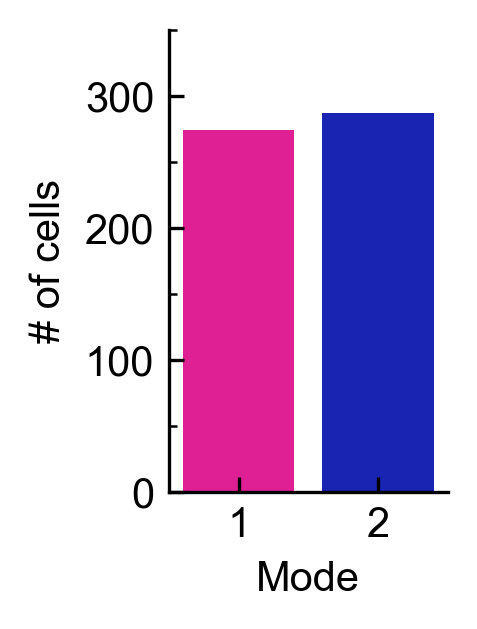

In [48]:
cols = [col for col in sub_fits_df.columns if sub_fits_df[col].dtype!='O']
aggdex = ['bud_id', 'produced_elongated_daughters', 'rls_suitable']
cols = cols + [col for col in aggdex if col not in cols]
cell_table = sub_fits_df.loc[:, cols].pivot_table(index=aggdex, aggfunc=np.median).reset_index()
total_cells = len(~cell_table.produced_elongated_daughters.isna())
n_mode_1 = len(cell_table[cell_table.produced_elongated_daughters])
n_mode_2 = len(cell_table[cell_table.produced_elongated_daughters==False])
d = {
    '# of cells': [n_mode_1, n_mode_2],
    'Mode': [1, 2]
}

df = pd.DataFrame(d)

fig, ax = plotting.figure_ax(width_scale=0.6)
fig.set_dpi(300)

kwargs = {
    'x': 'Mode',
    'y': '# of cells',
    'data': df,
    'palette': [other_colors['mode1'], other_colors['mode2']],
    'ax': ax
}

sns.barplot(**kwargs)
ax.set_ylim(0, 350)
plotting.format_ticks(ax, add_minor_x=False)
plotting.save_figure(fig, kwargs, ext='.svg')

### Comparing survival across aging modes

In [63]:
found_buds_dfs = []
end_event_types = []

# annotate RLS censorship using buds_df because 
# it is not accurately annotated in trace df
# or crop_roi_df data
for bud_serial in cell_table.bud_id:
    if bud_serial in sub_buds_df.bud_id.unique():
        cell_buds_df = sub_buds_df[sub_buds_df.bud_id==bud_serial]
        end_event_type = cell_buds_df.end_event_type.iloc[0]
        cell_table.loc[cell_table.bud_id==bud_serial, 'end_event_type'] = end_event_type
        end_event_types.append(end_event_type)

survival_fit_dfs = []
cell_table.loc[cell_table.produced_elongated_daughters, 'aging_mode'] = int(1)
cell_table.loc[cell_table.produced_elongated_daughters==False, 'aging_mode'] = int(2)
cell_table_rls_suitable = cell_table[cell_table.rls_suitable==True]
# cell_table_rls_suitable = cell_table_rls_suitable[cell_table_rls_suitable.potential_blue_light_exposure_during_filter_cube_switching==False]

for aging_mode in cell_table_rls_suitable.aging_mode.unique():
    
    try: 
        modedf = cell_table_rls_suitable[cell_table_rls_suitable.aging_mode==aging_mode]
        # Cannot compute survival curves if 0 length RLS in data
        modedf = modedf[modedf.rls!=0]
        n_cells = len(modedf)
        survival_df = fitting_tools.annotate_mdf_censors(modedf)
        survival_fit = fitting_tools.survival_fit(survival_df)
        d = {
            'generations_kmf': [np.float64(val) for val in survival_fit['x_kmf']],
            'fraction_surviving_kmf': [np.float64(val) for val in survival_fit['y_kmf']],
            'halflife_kmf': np.full(len(survival_fit['x_kmf']), survival_fit['kmf_halflife']),
            'n_cells': np.full(len(survival_fit['x_kmf']), n_cells)
        }
        survival_fit_df = pd.DataFrame(d)
        fitting_tools.add_conf_interval_to_survival_fit_df(survival_fit_df, survival_fit)
        for col in modedf.columns:
            if col not in survival_fit_df.columns:
                survival_fit_df.loc[:, col] = modedf[col].iloc[0]

        survival_fit_dfs.append(survival_fit_df)
    except Exception as e:
        print(f'Could not fit survival with following error:\n{e}')

survival_df = pd.concat(survival_fit_dfs, sort=False)
survival_df.index = range(0, len(survival_df))

Could not fit survival with following error:
'DataFrame' object has no attribute 'observed_since_start'
Could not fit survival with following error:
'DataFrame' object has no attribute 'observed_since_start'


ValueError: No objects to concatenate

NameError: name 'survival_df' is not defined

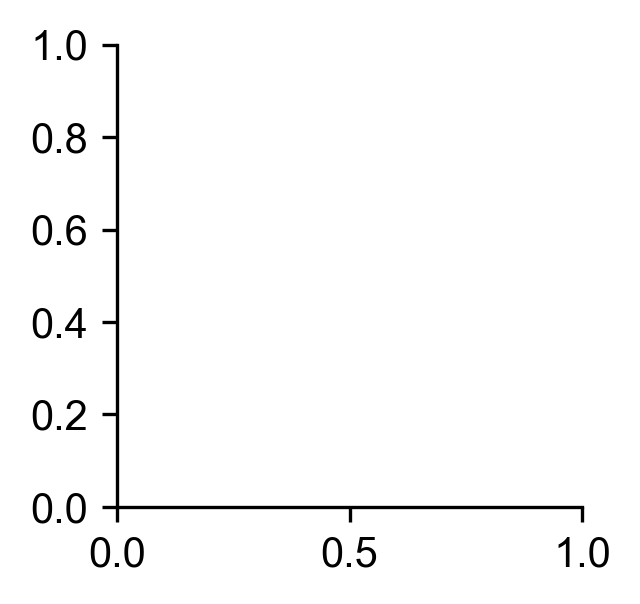

In [50]:
fig, ax = plotting.figure_ax()
fig.set_dpi(300)

mode1_rls = int(survival_df.loc[survival_df.aging_mode==1, 'halflife_kmf'].unique()[0])
mode2_rls = int(survival_df.loc[survival_df.aging_mode==2, 'halflife_kmf'].unique()[0])

kwargs = {
    'x': 'generations_kmf',
    'y': 'fraction_surviving_kmf',
    'hue': 'aging_mode',
    'palette': [other_colors['mode1'], other_colors['mode2']],
    'ax': ax,
    'data': survival_df,
    'hue_order': [1, 2]
}

sns.lineplot(**kwargs)
ax.set_xlim(0, 50)
ax.set_xticks(np.arange(0, 51, 10))
ax.set_ylim(0, 1.25)
ax.set_yticks(np.arange(0, np.max(ax.get_ylim())+0.1, 0.5))
plotting.format_ticks(ax)
ax.set_xlabel('# of buds produced')
ax.set_ylabel('Fraction surviving')
ax.legend(ax.get_legend_handles_labels()[0], [f'1, RLS={mode1_rls}', f'2, RLS={mode2_rls}'], title='Aging mode', frameon=False)
# Plot 95% of KMF estimate
for i, val in enumerate(kwargs['hue_order']):
    color = kwargs['palette'][i]
    df = survival_df[survival_df[kwargs['hue']]==val].reset_index()
    ax.fill_between(
        df.generations_kmf,
        df['KM_lower_95'],
        df['KM_upper_95'],
        color=color,
        alpha=0.3,
        edgecolor='white',
        interpolate=True
    )
# Calculate statistics
# using https://www.kdnuggets.com/2020/07/guide-survival-analysis-python-part-3.html
from lifelines.statistics import logrank_test

args = [
    survival_fit_dfs[0]['rls'],
    survival_fit_dfs[1]['rls']
]

logrankkwargs = {
    'event_observed_A': survival_fit_dfs[0]['rls_observed'],
    'event_observed_B': survival_fit_dfs[1]['rls_observed']
}
results = logrank_test(*args, **logrankkwargs)
results.print_summary()
rounded_p = np.round(results.p_value, int(str(results.p_value)[-2:]))
ax.annotate(f'p={rounded_p}', xy=(0.7, 0.4), xycoords='figure fraction')
plotting.save_figure(fig, kwargs, ext='.svg')

In [309]:
results.p_value

2.7150713219425075e-16

### k vs. buds before death vs. aggregate presence

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=dist_from_sen_y=cycle_duration_hrs_hue=contains_aggregate_linestyle=--.svg


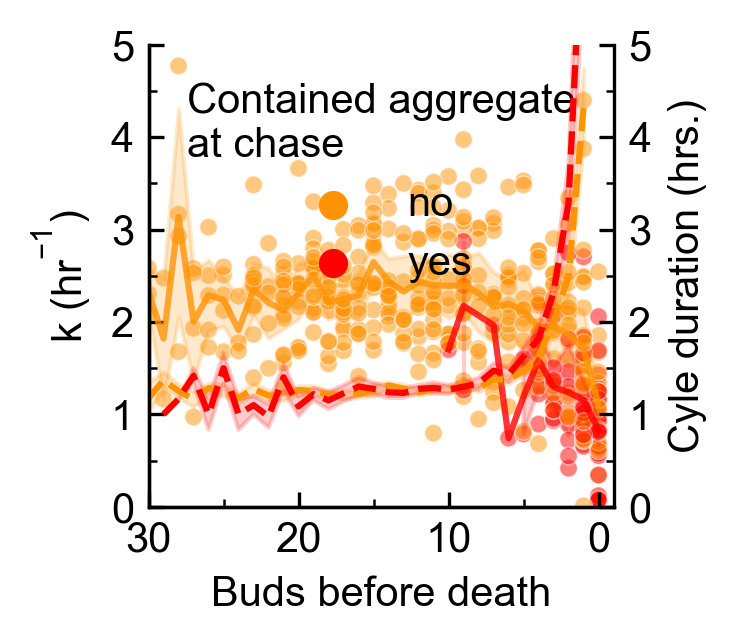

In [65]:
fig, ax = plotting.figure_ax()
fig.set_dpi(300)

kwargs = {
    'x': 'dist_from_sen',
    'y': 'b',
    'hue': 'contains_aggregate',
    'ax': ax,
    'data': sub_fits_df[~sub_fits_df.contains_aggregate.isna()],
    'palette': [strains_color_dict['JPC121'], 'red'],
}

sns.scatterplot(**kwargs, alpha=0.5, size=15)
sns.lineplot(**kwargs, alpha=0.8)
ax.legend(ax.get_legend_handles_labels()[0][0:2], ['no', 'yes'], title='Contained aggregate\nat chase', frameon=False, loc='best')
ax.set_xlim(30, -1)
ax.set_xticks(np.arange(0, np.max(ax.get_xlim())+0.1, 10))
ax.set_ylim(0, 5)
ax.set_yticks(np.arange(0, np.max(ax.get_ylim())+.1, 1))
plotting.format_ticks(ax)
ax.set_xlabel('Buds before death')
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)

ax2 = ax.twinx()
kwargs = {
    'x': 'dist_from_sen',
    'y': 'cycle_duration_hrs',
    'hue': 'contains_aggregate',
    'data': sub_buds_df,
    'ax': ax2,
    'palette': kwargs['palette'],
    'hue_order': ['no', 'yes'],
    'linestyle': '--'
}

sns.lineplot(**kwargs)
ax2.set_ylim(0, 5)
ax2.spines['top'].set_visible(False)
ax2.legend_.set_visible(False)
ax2.set_ylabel('Cyle duration (hrs.)')
plotting.format_ticks(ax2)

plotting.save_figure(fig, kwargs, ext='.svg')

### Looking for cells that had multiple cell divisions after aggregate formed to see if the daughter cell inherits the aggregate

In [66]:
sub_fits_df.loc[
    (sub_fits_df.dist_from_sen.between(1, 6)) & (sub_fits_df.contains_aggregate=='yes'),
    ['compartment_name', 'xy', 'cell_index', 'dist_from_sen']
].sort_values(by='dist_from_sen', ascending=False)

,compartment_name,xy,cell_index,dist_from_sen
397,20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,1.0,26.0,6.0
613,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,2.0,123.0,5.0
814,20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry,2.0,102.0,5.0
835,20221201_byc_JPC220_R-YFP-Su9_HSP104-mCherry,2.0,96.0,4.0
544,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,2.0,88.0,4.0
381,20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,0.0,17.0,4.0
538,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,4.0,175.0,4.0
422,20221118_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,4.0,193.0,4.0
413,20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,2.0,81.0,4.0
403,20221104_byc_JPC220_R-YFP-Su9_Hsp104-mCherry,0.0,9.0,4.0


### Strip plot of k vs. pre/post SEP vs. aggregate presence

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

yes_False vs. yes_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.812e-02 U_stat=3.660e+02
no_False vs. no_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.344e-14 U_stat=2.142e+04
no_False vs. yes_False: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.623e-01 U_stat=1.197e+03
no_True vs. yes_True: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.793e-07 U_stat=5.713e+03
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=contains_aggregate_y=b_hue=post_sep_dodge=True.svg


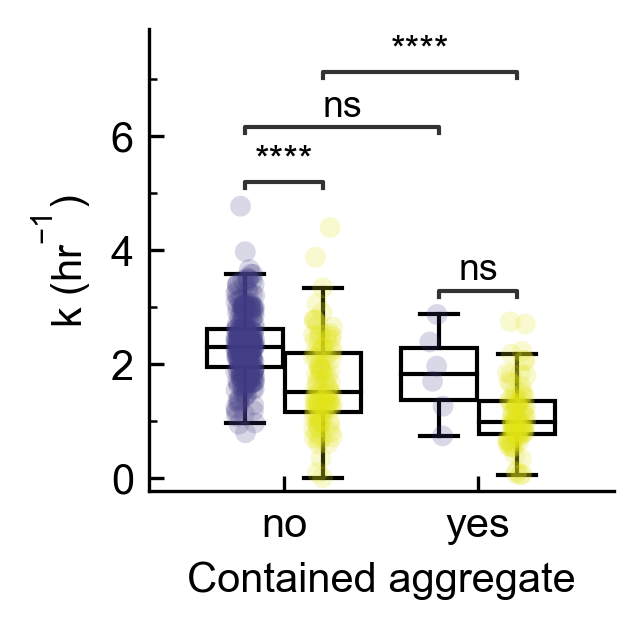

In [67]:
fig, ax = plotting.figure_ax(width_scale=1)
fig.set_dpi(300)

sub_fits_df.loc[sub_fits_df.dist_from_sen<5, 'post_sep'] = True
sub_fits_df.loc[sub_fits_df.dist_from_sen>5, 'post_sep'] = False

# ax.set_ylim(0, 4)

kwargs = {
    'x': 'contains_aggregate',
    'y': 'b',
    'hue': 'post_sep',
    'ax': ax,
    'data': sub_fits_df[sub_fits_df.b<=5],
    'palette': plotting.get_pre_post_sep_palette(),
    'hue_order': [False, True],
    'dodge': True,
    'order': ['no', 'yes']
}
# Plot stuff
sns.stripplot(**kwargs, alpha=0.2)
sns.boxplot(**kwargs, **plotting.transparent_boxes_prop_dict,
           showfliers=False)
# annotate t-test results
data=kwargs['data']
x = kwargs['x']
y = kwargs['y']
hue = kwargs['hue']
order = kwargs['order']
box_pairs=[
    (('no', True), ('no', False)),
    (('yes', True), ('yes', False)),
    (('no', False), ('yes', False)),
    (('no', True), ('yes', True))
]
test='Mann-Whitney'
text_format="full"
text_format='star'
loc="inside"
annotator = Annotator(ax, box_pairs, hue=hue, data=data, x=x, y=y, order=order,)
annotator.configure(test=test, text_format=text_format,
                    loc=loc, show_test_name=False,
                    line_width=1, fontsize=9,
                   comparisons_correction="bonferroni",
                   line_offset_to_group=5, line_offset=30)
annotator.apply_and_annotate()


ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)

ax.legend(
    ax.get_legend_handles_labels()[0][0:2],
    ['>5', '<5'],
    title='Buds before\ndeath',
    frameon=False,
    fontsize=8
)
ax.legend_.set_visible(False)
plotting.format_ticks(ax, add_minor_x=False)
ax.set_xticklabels(['no', 'yes'])
ax.set_xlabel('Contained aggregate')
plotting.save_figure(fig, kwargs, ext='.svg')
# ax.set_ylim(0, 5)

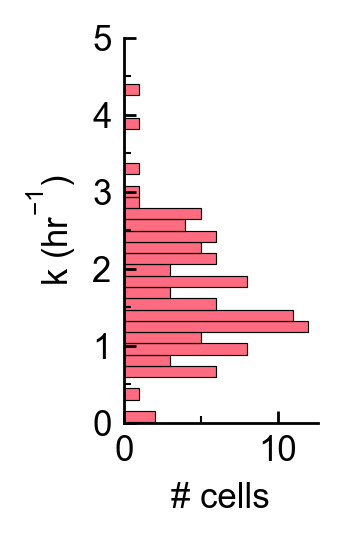

In [68]:
fig, ax = plotting.figure_ax(width_scale=0.5)

kwargs = {
    'y': 'b',
    'data': sub_fits_df[(sub_fits_df.post_sep==True) & (sub_fits_df.contains_aggregate=='no')],
    'ax': ax,
    'color': ratecolor,
    'bins': 30
}

sns.histplot(**kwargs)

ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.set_xlabel('# cells')
ax.set_ylim(0, 5)
plotting.format_ticks(ax)

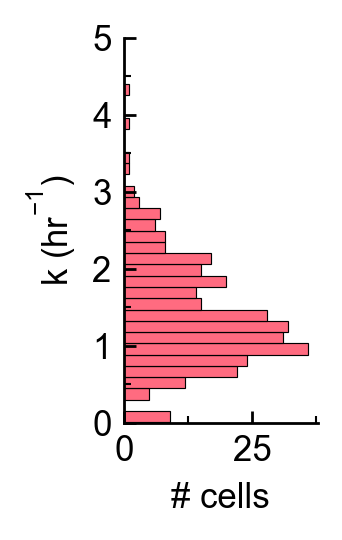

In [69]:
fig, ax = plotting.figure_ax(width_scale=0.5)

kwargs = {
    'y': 'b',
    'data': sub_fits_df[(sub_fits_df.post_sep==True)],
    'ax': ax,
    'color': ratecolor,
    'bins': 30
}

sns.histplot(**kwargs)

ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
ax.set_xlabel('# cells')
ax.set_ylim(0, 5)
plotting.format_ticks(ax)

### Survival curves with and without aggregate

In [78]:
found_buds_dfs = []
end_event_types = []
# annotate RLS censorship using buds_df because 
# it is not accurately annotated in trace df
# or crop_roi_df data
for bud_serial in cell_table.bud_id:
    if bud_serial in sub_buds_df.bud_id.unique():
        cell_buds_df = sub_buds_df[sub_buds_df.bud_id==bud_serial]
        end_event_type = cell_buds_df.end_event_type.iloc[0]
        cell_table.loc[cell_table.bud_id==bud_serial, 'end_event_type'] = end_event_type
        end_event_types.append(end_event_type)

survival_fit_dfs = []
survival_fits = []

cell_table_rls_suitable = cell_table[cell_table.rls_suitable==True]

for aging_mode in cell_table_rls_suitable.contains_aggregate.unique():
    
    try:
        modedf = cell_table_rls_suitable[cell_table_rls_suitable.contains_aggregate==aging_mode]
        # Cannot compute survival curves if 0 length RLS in data
        modedf = modedf[modedf.rls!=0]
        n_cells = len(modedf)
        survival_df = fitting_tools.annotate_mdf_censors(modedf)
        survival_fit = fitting_tools.survival_fit(survival_df)
        survival_fits.append(survival_fit)
        d = {
            'generations_kmf': [np.float64(val) for val in survival_fit['x_kmf']],
            'fraction_surviving_kmf': [np.float64(val) for val in survival_fit['y_kmf']],
            'halflife_kmf': np.full(len(survival_fit['x_kmf']), survival_fit['kmf_halflife']),
            'n_cells': np.full(len(survival_fit['x_kmf']), n_cells)
        }
        survival_fit_df = pd.DataFrame(d)
        # Add 95% CI of mean
        fitting_tools.add_conf_interval_to_survival_fit_df(survival_fit_df, survival_fit)
        # Annotate the survival fit df with strain information
        for col in modedf.columns:
            if col not in survival_fit_df.columns:
                survival_fit_df.loc[:, col] = modedf[col].iloc[0]

        survival_fit_dfs.append(survival_fit_df)
    except Exception as e:
        print(f'Could not fit survival with following error:\n{e}')

survival_df = pd.concat(survival_fit_dfs, sort=False)
survival_df.index = range(0, len(survival_df))

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          60.00 <0.005     46.58

9.485737571073578e-15
Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=generations_kmf_y=fraction_surviving_kmf_hue=contains_aggregate.svg


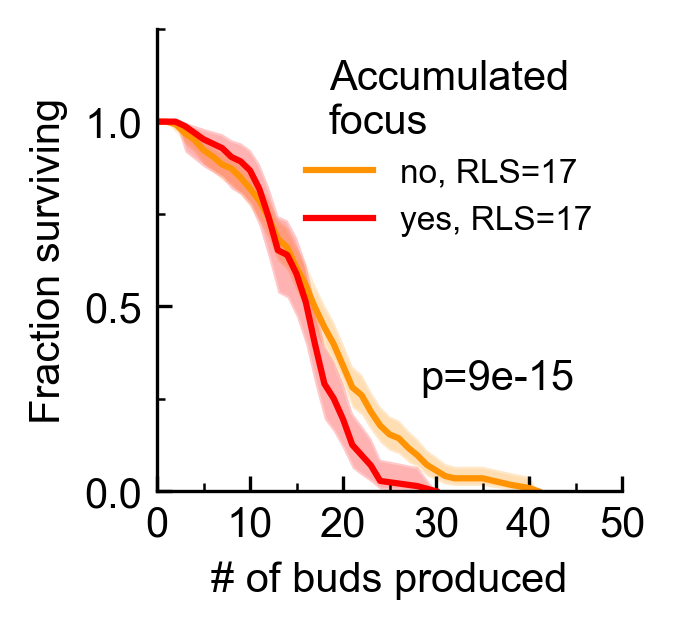

In [80]:
fig, ax = plotting.figure_ax()
fig.set_dpi(300)

mode1_rls = int(survival_df.loc[survival_df.contains_aggregate=='yes', 'halflife_kmf'].unique()[0])
mode2_rls = int(survival_df.loc[survival_df.contains_aggregate=='no', 'halflife_kmf'].unique()[0])

kwargs = {
    'x': 'generations_kmf',
    'y': 'fraction_surviving_kmf',
    'hue': 'contains_aggregate',
    'ax': ax,
    'data': survival_df,
    'palette': [strains_color_dict['JPC121'], 'red'],
    'hue_order': ['no', 'yes']
}
# plot survival data
sns.lineplot(**kwargs)
# Plot 95% of KMF estimate
for i, val in enumerate(survival_df[kwargs['hue']].unique()):
    color = kwargs['palette'][i]
    df = survival_df[survival_df[kwargs['hue']]==val].reset_index()
    ax.fill_between(
        df.generations_kmf,
        df['KM_lower_95'],
        df['KM_upper_95'],
        color=color,
        alpha=0.3,
        edgecolor='white',
        interpolate=True
    )
ax.set_xlim(0, 50)
ax.set_xticks(np.arange(0, 51, 10))
ax.set_ylim(0, 1.25)
ax.set_yticks(np.arange(0, np.max(ax.get_ylim())+0.1, 0.5))
plotting.format_ticks(ax)
ax.set_xlabel('# of buds produced')
ax.set_ylabel('Fraction surviving')
ax.legend(
    ax.get_legend_handles_labels()[0],
    [f'no, RLS={mode1_rls}', f'yes, RLS={mode2_rls}'],
    title='Accumulated\nfocus',
    frameon=False,
    loc='best',
    fontsize=8)
# Calculate statistics
from lifelines.statistics import logrank_test

args = [
    survival_fit_dfs[0]['rls'],
    survival_fit_dfs[1]['rls']
]

logrankkwargs = {
    'event_observed_A': survival_fit_dfs[0]['rls_observed'],
    'event_observed_B': survival_fit_dfs[1]['rls_observed']
}
results = logrank_test(*args, **logrankkwargs)
results.print_summary()
rounded_p = np.round(results.p_value, int(str(results.p_value)[-2:]))
ax.annotate(f'p={rounded_p}', xy=(0.7, 0.4), xycoords='figure fraction')
print(results.p_value)

plotting.save_figure(fig, kwargs, ext='.svg')

### Cycle duration vs. buds before death vs. aggregate presence

### Between mode 1 and mode 2, who is more likely to contain an aggregate?

Saved figure at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\x=produced_elongated_daughters_y=counts_hue=contains_aggregate_dodge=False.svg


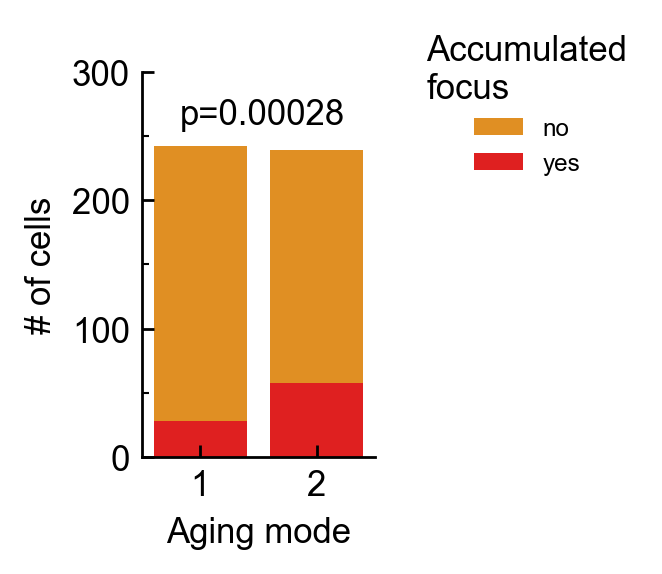

In [86]:
fig, ax = plotting.figure_ax(width_scale=0.6)
subdf = sub_fits_df[~sub_fits_df.contains_aggregate.isna()]
cols = [
    'contains_aggregate',
    'produced_elongated_daughters',
    'b',
]

aggdex = [
    'produced_elongated_daughters',
    'contains_aggregate',
]
pivottable = subdf.loc[:, cols].pivot_table(index=aggdex, aggfunc='count').reset_index()
from statsmodels.stats.proportion import proportions_ztest
total_mode_1 = pivottable.set_index('produced_elongated_daughters').loc[True, 'b'].sum()
total_mode_2 = pivottable.set_index('produced_elongated_daughters').loc[False, 'b'].sum()
mode_1_with_agg = pivottable.set_index([
    'produced_elongated_daughters',
    'contains_aggregate'
]).loc[(True, 'yes'), 'b']
mode_2_with_agg = pivottable.set_index([
    'produced_elongated_daughters',
    'contains_aggregate'
]).loc[(False, 'yes'), 'b']
# Format the table so it can be shown as a proper stacked bar
pivottable.loc[:, 'counts'] = np.nan
pivottable.loc[:, 'counts'] = [total_mode_2, mode_2_with_agg, total_mode_1, mode_1_with_agg]
# The below is correct but is not setting counts values on the original dataframe
# pivottable.set_index(aggdex).loc[(True, 'no'), 'counts'] = total_mode_1
# pivottable.set_index(aggdex).loc[(False, 'no'), 'counts'] = total_mode_2
# pivottable.set_index(aggdex).loc[(True, 'yes'), 'counts'] = mode_1_with_agg
# pivottable.set_index(aggdex).loc[(False, 'yes'), 'counts'] = mode_2_with_agg
# Calculate hypergeometric chi sq test stat and p-value
count = np.array([mode_1_with_agg, mode_2_with_agg])
nobs = np.array([total_mode_1, total_mode_2])
stat, pval = proportions_ztest(count, nobs)

kwargs = {
    'x': 'produced_elongated_daughters',
    'y': 'counts',
    'order': [True, False],
    'hue': 'contains_aggregate',
    'data': pivottable,
    'ax': ax,
    'palette': [strains_color_dict['JPC121'], 'red'],
    'hue_order': ['no', 'yes'],
    'dodge': False
}

sns.barplot(**kwargs)
ax.set_xticklabels(['1', '2'])
ax.set_ylabel('# of cells')
ax.set_xlabel('Aging mode')
ax.set_ylim(0, 300)
ax.annotate("p={}".format(np.round(pval, 5)), xycoords='figure fraction', xy=(0.6, 0.9))

ax.legend(
    ax.get_legend_handles_labels()[0],
    ax.get_legend_handles_labels()[1],
    title='Accumulated\nfocus',
    frameon=False,
    bbox_to_anchor=(1, 1), bbox_transform=fig.transFigure, fontsize=7)

plotting.format_ticks(ax, add_minor_x=False)
plotting.save_figure(fig, kwargs, ext='.svg')

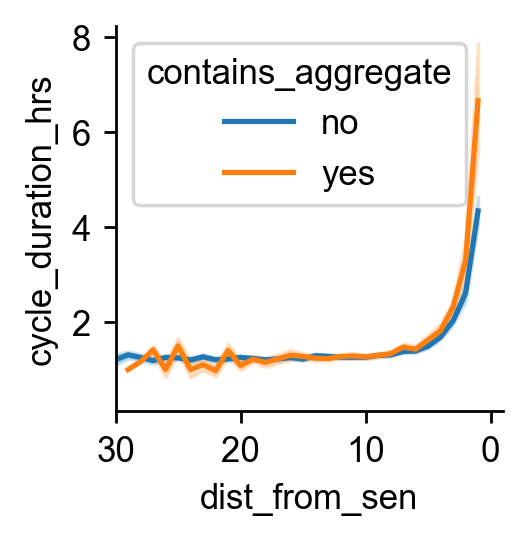

In [336]:
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'dist_from_sen',
    'y': 'cycle_duration_hrs',
    'hue': 'contains_aggregate',
    'data': sub_buds_df,
    'ax': ax,
}

sns.lineplot(**kwargs)

ax.set_xlim(30, -1)
ax.set_xticks(np.arange(0, np.max(ax.get_xlim())+0.1, 10))

## Correct and complete annotation of cell cycle information on `fits_df` for analsysi of xplanatory variabels for degradation rate approaching senescence

In [14]:
strains = ['JPC121', 'JPC220', 'JPC146']
tet_stock_concn = '1000X'
sub_fits_df = fits_df[fits_df.strain_name.isin(strains)]
sub_fits_df = sub_fits_df[sub_fits_df.tet_stock_concn==tet_stock_concn]
sub_fits_df = sub_fits_df[sub_fits_df.dist_from_sen>=0]

In [42]:
collection_interval_mins = 10
sub_fits_df.loc[:, 'measdex'] = sub_fits_df.compartment_name.str.cat(sub_fits_df.cell_index.astype(int).astype(str), sep='-')
unique_measdices = sub_fits_df.measdex.unique()
i=1
for measdex in unique_measdices:
    print(f'Measuring cell chase {i} of {len(unique_measdices)}', end='\r')
    measdex_bool = sub_fits_df.measdex==measdex
    cell_index = int(sub_fits_df.loc[measdex_bool, 'cell_index'].iloc[0])
    # Use the cell's crop ROI dataframe .csv file to annotate whether
    # the cell contains an aggregate at the time the chase performed
    compdir = sub_fits_df.loc[measdex_bool, 'compartment_dir'].iloc[0]
    crop_roi_df = database.get_crop_roi_df_from_cell_index_compdir(cell_index, compdir)
    if 'contains_aggregate' in crop_roi_df.columns:
        contains_aggregate = crop_roi_df.contains_aggregate.iloc[0]
    else:
        contains_aggregate = np.nan
    sub_fits_df.loc[measdex_bool, 'contains_aggregate'] = contains_aggregate
    abs_chase_frame = sub_fits_df[measdex_bool].abs_chase_frame.iloc[0]
    # Read in and analyze the bud_rois_df
    bud_rois_zip_path = sub_fits_df[measdex_bool].bud_roi_set_path.iloc[0]
    cell_buds_df = files.read_rectangular_rois_as_df(bud_rois_zip_path)
    cell_buds_df.sort_values(by='position', ascending=True, inplace=True)
    cell_buds_df.reset_index(inplace=True)
    # Last frame is the death frame so it's not included in cycle duration measurements
    cell_buds_df.loc[:cell_buds_df.index.max()-2, 'cycle_duration_frames'] = np.diff(cell_buds_df.position[0:-1])
    cell_buds_df.loc[:, 'cycle_duration_hrs'] = (cell_buds_df.cycle_duration_frames*collection_interval_mins)/60
    cell_buds_df.loc[:, 'frame'] = cell_buds_df.position - 1
    cell_buds_df.loc[:, 'cycle_number'] = cell_buds_df.index
    database.annotate_daughter_shapes(cell_buds_df)
    n_long_daughters = len(cell_buds_df[cell_buds_df.bud_shape=='long'])
    n_round_daughters = len(cell_buds_df[cell_buds_df.bud_shape=='round'])
    # Annotate the last frame at which the cell was seen alive
    # and get rid of it from the data
    cell_buds_df.loc[:, 'death_frame'] = cell_buds_df.frame.max()
    cell_buds_df = cell_buds_df.loc[0:cell_buds_df.index.max()-1, :]
    deltas = abs_chase_frame - cell_buds_df.frame
    # Ideally we want the cell cycle that's occuring during the chase
    # so we first try selecting those that start before or at the chase
    # frame
    positive_deltas = deltas[deltas>=0]
    if len(positive_deltas) > 0:
        cycle_number_closest_chase = np.argmin(positive_deltas)
    # if we can't find a cell cycle starting before or after the chase
    # (probably the case in a lot of t0 chases) we choose the cell 
    # cycle that starts closest to the chase
    else:
        abs_deltas = np.abs(deltas)
        cycle_number_closest_chase = np.argmin(abs_deltas)

    cycle_duration_at_chase = cell_buds_df.loc[cycle_number_closest_chase, 'cycle_duration_hrs']
    if np.isnan(cycle_duration_at_chase):
        try:
            # print(f'Closest cycle duration could not be calculated, using the one before')
            cycle_number_second_closest_to_chase = cycle_number_closest_chase-1
            cycle_duration_at_chase = cell_buds_df.loc[cycle_number_second_closest_to_chase, 'cycle_duration_hrs']
        except:
            pass
    sub_fits_df.loc[measdex_bool, 'cycle_duration_at_chase'] = cycle_duration_at_chase
    sub_fits_df.loc[measdex_bool, 'rls'] = len(cell_buds_df)
    sub_fits_df.loc[measdex_bool, 'n_long_daughters'] = n_long_daughters
    sub_fits_df.loc[measdex_bool, 'n_round_daughters'] = n_round_daughters
    # Only consider a cell's age at chase to be observed if the cell's
    # bud production started being observed in the first 3 hours of the expt
    if sub_fits_df.frame.min() < 19:
        sub_fits_df.loc[measdex_bool, 'age_at_chase'] = len(cell_buds_df[cell_buds_df.frame<=abs_chase_frame])
        sub_fits_df.loc[measdex_bool, 'rls_observed'] = True
    else:
        sub_fits_df.loc[measdex_bool, 'age_at_chase'] = np.nan
        sub_fits_df.loc[measdex_bool, 'rls_observed'] = False
    last_bud_hours = (cell_buds_df.frame.max()*collection_interval_mins)/60
    abs_chase_hours = (abs_chase_frame*collection_interval_mins)/60
    sub_fits_df.loc[measdex_bool, 'hours_after_last_bud'] = abs_chase_hours - last_bud_hours

    i+=1

sep_border = 5
sub_fits_df.loc[sub_fits_df.dist_from_sen<sep_border, 'post_sep'] = True
sub_fits_df.loc[sub_fits_df.dist_from_sen>sep_border, 'post_sep'] = False
n_long_thresh = 1
sub_fits_df.loc[sub_fits_df.n_long_daughters>=n_long_thresh, 'produced_elongated_daughters'] = True
sub_fits_df.loc[sub_fits_df.n_long_daughters==0, 'produced_elongated_daughters'] = False
sub_fits_df.loc[sub_fits_df.dist_from_sen>5, 'post_sep'] = False
sub_fits_df.loc[sub_fits_df.dist_from_sen<5, 'post_sep'] = True

### K vs. cycle duration at chase vs. pre/post SEP hue

Figure saved at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\fig.png


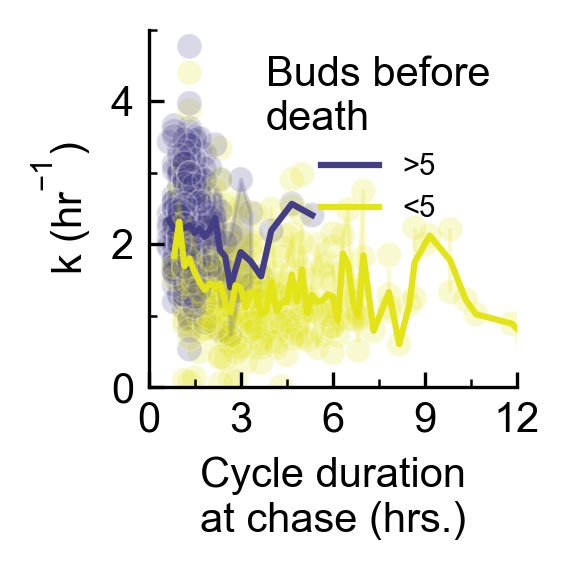

In [49]:
palette = plotting.get_pre_post_sep_palette()
sep_border = 5
sub_fits_df.loc[sub_fits_df.dist_from_sen<sep_border, 'post_sep'] = True
sub_fits_df.loc[sub_fits_df.dist_from_sen>sep_border, 'post_sep'] = False
sub_fits_df = sub_fits_df[sub_fits_df.cycle_duration_at_chase>0.5]
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
scatterkwargs = {
    'x': 'cycle_duration_at_chase',
    'y': 'b',
    'hue': 'post_sep',
    'palette': palette,
    'data': sub_fits_df,
    'ax': ax,
    'alpha': 0.2
}
sns.scatterplot(**scatterkwargs)

linekwargs = {
    'x': 'cycle_duration_at_chase',
    'y': 'b',
    'hue': 'post_sep',
    'palette': palette,
    'data': sub_fits_df,
    'estimator': 'mean',
    'ax': ax,
    'alpha': 1
}

sns.lineplot(**linekwargs)

ax.set_xlim(0, 12)
ax.set_xticks(np.arange(0, 12.1, 3))
ax.set_ylim(0, 5)
ax.set_yticks(np.arange(0, 5.1, 2))
ax.set_xlabel('Cycle duration\nat chase (hrs.)')
ax.set_ylabel(plotting.annoying_strings().k_inverse_hrs)
plotting.format_ticks(ax)
handles = ax.get_legend_handles_labels()[0][2:4]
labels = ['>5', '<5']
ax.legend(handles, labels, title='Buds before\ndeath', frameon=False, fontsize=7)
# plotting.legend_outside()
plt.tight_layout()

savepath = os.path.abspath(os.path.join(constants.byc_data_dir, f'meta/plots/fig.png'))
fig.savefig(savepath)
print(f'Figure saved at\n{savepath}')

### k vs. age at chase with hue dist_from_sen

Figure saved at
C:\Users\johnp\Dropbox\Projects\byc\data\meta\plots\fig.png


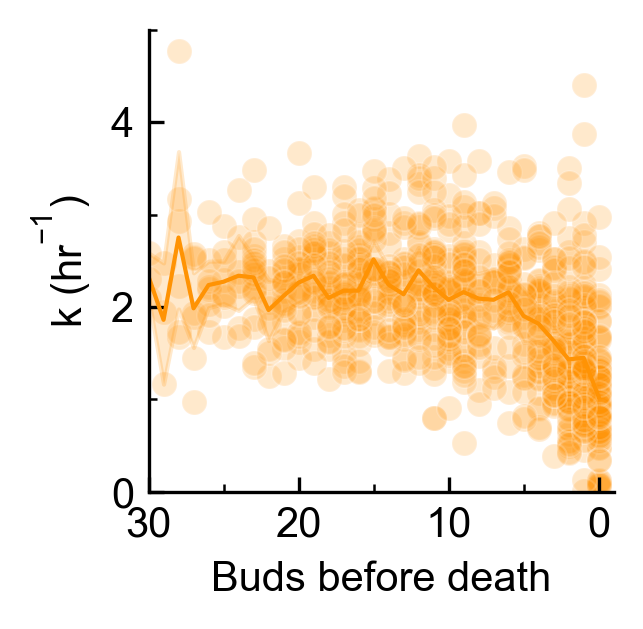

In [16]:
fig, ax = plotting.figure_ax()
fig.set_dpi(300)
ratecolor = plotting.strains_color_dict['JPC121']
kwargs = {
    'x': 'dist_from_sen',
    'y': 'b',
    'hue': 'dist_from_sen',
    'palette': 'viridis_r',
    'data': sub_fits_df,
    'ax': ax,
    'alpha': 0.4,
}


kwargs = {
    'x': 'dist_from_sen',
    'y': 'b',
    'data': sub_fits_df,
    'ax': ax,
    'alpha': 0.2,
    'color':ratecolor,
}

sns.scatterplot(**kwargs)
sns.lineplot(
    x=kwargs['x'],
    y=kwargs['y'],
    data=kwargs['data'],
    color=ratecolor,
    linewidth=1
)

ax.set_xlim(30, -1)
ax.set_xticks(np.arange(0, np.max(ax.get_xlim())+1, 10))
ax.set_ylim(0, 5)
ax.set_yticks(np.arange(0, 5.1, 2))
plotting.format_ticks(ax)
if ax.legend_:
    ax.legend_.set_visible(False)
ylabel = plotting.annoying_strings().k_inverse_hrs
ax.set_ylabel(ylabel)
ax.set_xlabel('Buds before death')

savepath = os.path.abspath(os.path.join(constants.byc_data_dir, f'meta/plots/fig.png'))
fig.savefig(savepath)
print(f'Figure saved at\n{savepath}')
mdistfromsen = int(np.max(sub_fits_df.dist_from_sen))
# plotting.plot_dist_from_sen_palette_key(
#     max_dist_from_sen=mdistfromsen,
#     major_tick_space=10,
#     minor_tick_space=5
#     )

### Cycle duration by age

(0.0, 10.0)

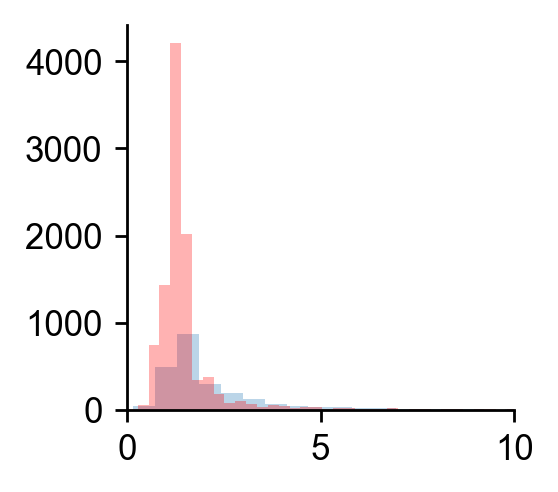

In [103]:
fig, ax = plotting.figure_ax()

ax.hist(sub_buds_df[sub_buds_df.cycle_number>15].cycle_duration_hrs, bins=100, alpha=0.3)
ax.hist(sub_buds_df[sub_buds_df.cycle_number<=15].cycle_duration_hrs, bins=100, color='red', alpha=0.3)
ax.set_xlim(0, 10)

Text(0.5, 0, 'Cycle #')

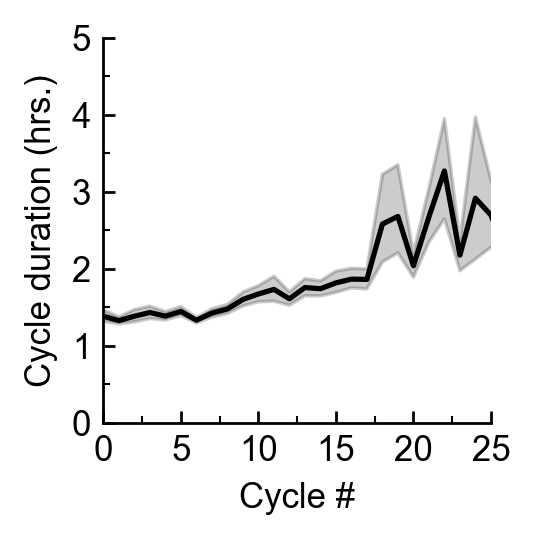

In [116]:
sub_buds_df = buds_df[buds_df.strain_name.isin(strains)]
sub_buds_df = sub_buds_df[sub_buds_df.tet_stock_concn=='1000X']
sub_buds_df = sub_buds_df[sub_buds_df.first_bud_frame<=18]
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'cycle_number',
    'y': 'cycle_duration_hrs',
    'data': sub_buds_df,
    'ax': ax,
    'color': 'black',
}

sns.lineplot(**kwargs)
# sns.scatterplot(**kwargs)
ax.set_xlim(0, 25)
ax.set_xticks(np.arange(0, np.max(ax.get_xlim())+1, 5))
ax.set_ylim(0, 5)
plotting.format_ticks(ax)

ax.set_ylabel('Cycle duration (hrs.)')
ax.set_xlabel('Cycle #')

Text(0.5, 0, 'Buds before death')

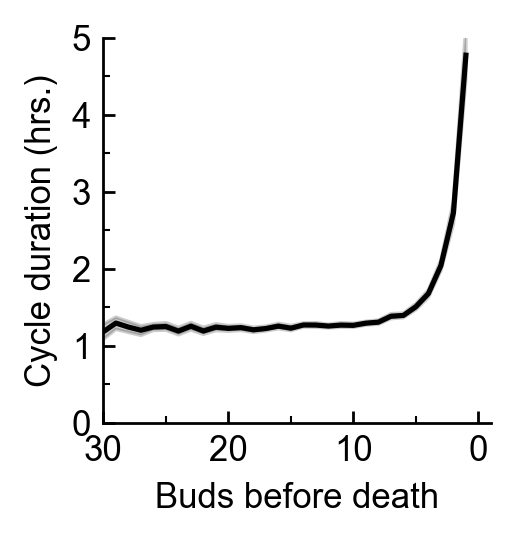

In [134]:
sub_buds_df = buds_df[buds_df.strain_name.isin(strains)]
sub_buds_df = sub_buds_df[sub_buds_df.tet_stock_concn=='1000X']
sub_buds_df = sub_buds_df[sub_buds_df.first_bud_frame<=18]
fig, ax = plotting.figure_ax()

kwargs = {
    'x': 'dist_from_sen',
    'y': 'cycle_duration_hrs',
    'data': sub_buds_df,
    'ax': ax,
    'color': 'black',
}

sns.lineplot(**kwargs)
# sns.scatterplot(**kwargs)
ax.set_xlim(30, -1)
ax.set_xticks(np.arange(0, np.max(ax.get_xlim())+1, 10))
ax.set_ylim(0, 5)
plotting.format_ticks(ax)

ax.set_ylabel('Cycle duration (hrs.)')
ax.set_xlabel('Buds before death')